In [54]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the current directory to path to import pyXcorrDIA
sys.path.append('.')
from pyXcorrDIA import FastXCorr, MassSpectrum, PeptideCandidate

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Imports successful!")

# Create a FastXCorr instance to show its properties
xcorr_test = FastXCorr()
print(f"FastXCorr class loaded with:")

# Safely display attributes that should exist
try:
    print(f"  - Bin width: {xcorr_test.bin_width}")
except AttributeError:
    print("  - Bin width: Not available")

try:
    print(f"  - Mass range: {xcorr_test.mass_range}")
except AttributeError:
    print("  - Mass range: Not available")

try:
    print(f"  - Number of bins: {xcorr_test.num_bins}")
except AttributeError:
    print("  - Number of bins: Not available")

# Check for BIN macro parameters
try:
    print(f"  - Inverse bin width: {xcorr_test.inverse_bin_width}")
except AttributeError:
    print("  - Inverse bin width: Not available (calculated as 1.0/bin_width)")

try:
    print(f"  - BIN offset: {xcorr_test.bin_offset}")
except AttributeError:
    print("  - BIN offset: Not available (hardcoded as 0.4)")

print("Ready to analyze XCorr preprocessing steps!")

Imports successful!
FastXCorr class loaded with:
  - Bin width: 1.0005079
  - Mass range: (0, 2000)
  - Number of bins: 1999
  - Inverse bin width: 0.9994923578314575
  - BIN offset: 0.4
Ready to analyze XCorr preprocessing steps!


In [55]:
# Initialize the XCorr engine and read the spectrum
xcorr_engine = FastXCorr()

# CONFIGURATION: Set which spectrum to analyze
# Options:
#   - Set to a specific scan ID (e.g., 36889) to analyze that spectrum
#   - Set to None or 'first' to use the first MS2 spectrum
#   - Set to 'random' to pick a random spectrum
TARGET_SPECTRUM = 2  # Change this value to analyze different spectra

# PLOTTING CONFIGURATION: Set m/z range for plots
# Options:
#   - Set to None to use the full m/z range of the spectrum (dynamic)
#   - Set to [min_mz, max_mz] to use a custom range (e.g., [300, 1500])
PLOT_MZ_RANGE = None  # Change to [300, 1500] for fixed range, or None for dynamic

# Read mzML file
mzml_file = 'Ste-2025-01-08_I_1Th_GPFDIA_400-500_15m_015.mzML'
print(f"Reading {mzml_file}...")

if TARGET_SPECTRUM is None or TARGET_SPECTRUM == 'first':
    print("Using first MS2 spectrum...")
    spectra = xcorr_engine.read_mzml(mzml_file, max_spectra=1)
elif TARGET_SPECTRUM == 'random':
    print("Loading all spectra to pick a random one...")
    all_spectra = xcorr_engine.read_mzml(mzml_file, max_spectra=-1)  # Use -1 instead of None
    if all_spectra:
        import random
        spectrum = random.choice(all_spectra)
        print(f"Randomly selected spectrum {spectrum.scan_id}")
        spectra = [spectrum]
    else:
        spectra = []
else:
    # Use fast single spectrum lookup for specific scan IDs
    print(f"Using fast lookup for spectrum {TARGET_SPECTRUM}...")
    try:
        spectrum = xcorr_engine.read_single_spectrum(mzml_file, str(TARGET_SPECTRUM))
        print(f"✓ Successfully loaded spectrum {TARGET_SPECTRUM} using fast mzML index lookup!")
        spectra = [spectrum]
    except ValueError as e:
        print(f"Fast lookup failed: {e}")
        print("Falling back to sequential search...")
        all_spectra = xcorr_engine.read_mzml(mzml_file, max_spectra=-1)
        
        # Find the target spectrum
        target_spectrum = None
        for spec in all_spectra:
            if spec.scan_id == str(TARGET_SPECTRUM):
                target_spectrum = spec
                break
        
        if target_spectrum is None:
            print(f"Spectrum {TARGET_SPECTRUM} not found!")
            print(f"Available scan IDs (first 20): {[s.scan_id for s in all_spectra[:20]]}")
            if len(all_spectra) > 20:
                print(f"... and {len(all_spectra) - 20} more spectra")
            print("Using first spectrum as fallback...")
            spectra = [all_spectra[0]] if all_spectra else []
        else:
            print(f"Found spectrum {TARGET_SPECTRUM} via sequential search!")
            spectra = [target_spectrum]

if not spectra:
    print("No spectra found!")
else:
    spectrum = spectra[0]
    
    # Determine plot range
    if PLOT_MZ_RANGE is None:
        # Use dynamic range based on actual data
        plot_min_mz = spectrum.mz_array.min()
        plot_max_mz = spectrum.mz_array.max()
        print(f"Using dynamic m/z range: {plot_min_mz:.1f} - {plot_max_mz:.1f}")
    else:
        # Use custom range
        plot_min_mz, plot_max_mz = PLOT_MZ_RANGE
        print(f"Using custom m/z range: {plot_min_mz} - {plot_max_mz}")
    
    print(f"\n=== SELECTED SPECTRUM ===")
    print(f"Scan ID: {spectrum.scan_id}")
    print(f"Precursor m/z: {spectrum.precursor_mz:.4f}")
    print(f"Charge: {spectrum.charge}")
    print(f"Isolation window: [{spectrum.isolation_window_lower:.5f}-{spectrum.isolation_window_upper:.5f}]")
    print(f"Number of peaks: {len(spectrum.mz_array)}")
    print(f"m/z range: {spectrum.mz_array.min():.2f} - {spectrum.mz_array.max():.2f}")
    print(f"Intensity range: {spectrum.intensity_array.min():.0f} - {spectrum.intensity_array.max():.0f}")
    print(f"Plot m/z range: {plot_min_mz:.1f} - {plot_max_mz:.1f}")
    print("=========================")

Reading Ste-2025-01-08_I_1Th_GPFDIA_400-500_15m_015.mzML...
Using fast lookup for spectrum 2...
✓ Successfully loaded spectrum 2 using fast mzML index lookup!
Using dynamic m/z range: 200.9 - 711.2

=== SELECTED SPECTRUM ===
Scan ID: 2
Precursor m/z: 400.9322
Charge: 2
Isolation window: [400.43219-401.43219]
Number of peaks: 90
m/z range: 200.93 - 711.21
Intensity range: 21 - 3856
Plot m/z range: 200.9 - 711.2
✓ Successfully loaded spectrum 2 using fast mzML index lookup!
Using dynamic m/z range: 200.9 - 711.2

=== SELECTED SPECTRUM ===
Scan ID: 2
Precursor m/z: 400.9322
Charge: 2
Isolation window: [400.43219-401.43219]
Number of peaks: 90
m/z range: 200.93 - 711.21
Intensity range: 21 - 3856
Plot m/z range: 200.9 - 711.2


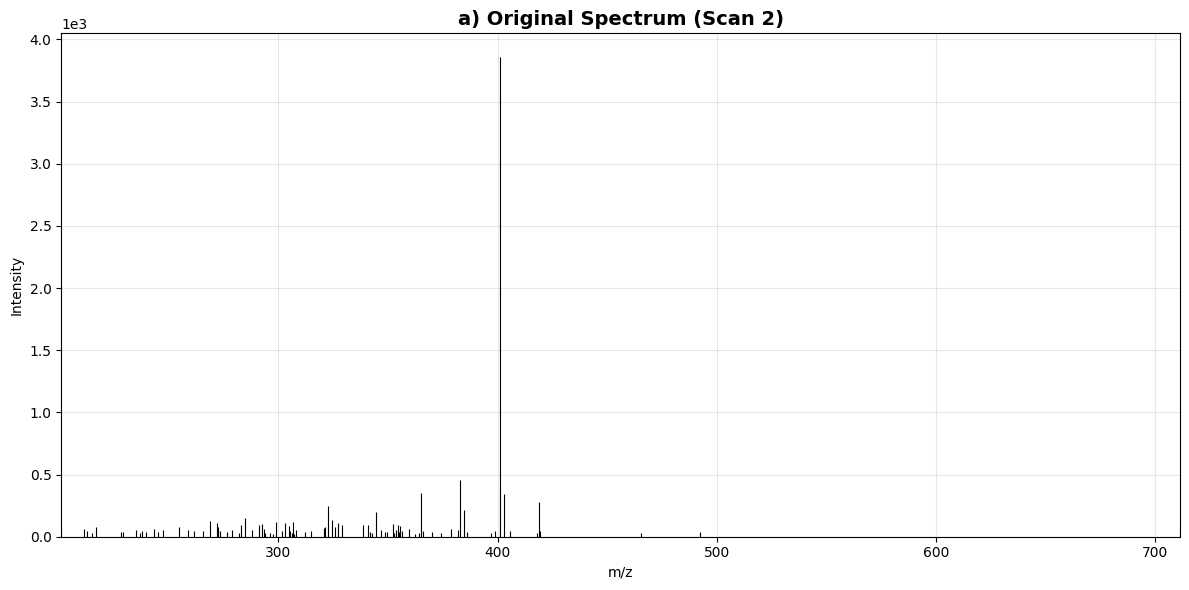

Original spectrum stats:
  Number of peaks: 90
  Max intensity: 3856
  Mean intensity: 120
  Plot range: 200.9 - 711.2 m/z


In [56]:
# Step 1: Plot the original raw spectrum
plt.figure(figsize=(12, 6))
plt.vlines(spectrum.mz_array, 0, spectrum.intensity_array, colors='k', linewidth=0.8)
plt.title(f'a) Original Spectrum (Scan {spectrum.scan_id})', fontsize=14, fontweight='bold')
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.grid(True, alpha=0.3)
plt.xlim(plot_min_mz, plot_max_mz)
plt.ylim(0, None)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.show()

print(f"Original spectrum stats:")
print(f"  Number of peaks: {len(spectrum.mz_array)}")
print(f"  Max intensity: {spectrum.intensity_array.max():.0f}")
print(f"  Mean intensity: {spectrum.intensity_array.mean():.0f}")
print(f"  Plot range: {plot_min_mz:.1f} - {plot_max_mz:.1f} m/z")

=== CREATING FIGURE OF XCORR PREPROCESSING USING pyXcorrDIA.py FUNCTIONS ===
Using spectrum 2 from cell 3
a) Original spectrum: 90 peaks
b) Creating binned + sqrt-transformed spectrum using pyXcorrDIA.py...
   Binned into 80 bins, max intensity: 62.09
c) Applying MakeCorrData windowing using pyXcorrDIA._make_corr_data()...
   Windowed spectrum max: 50.00, non-zero bins: 80
d) Applying Fast XCorr preprocessing using pyXcorrDIA.preprocess_for_xcorr()...
   Preprocessed range: [-21.233, 61.332]


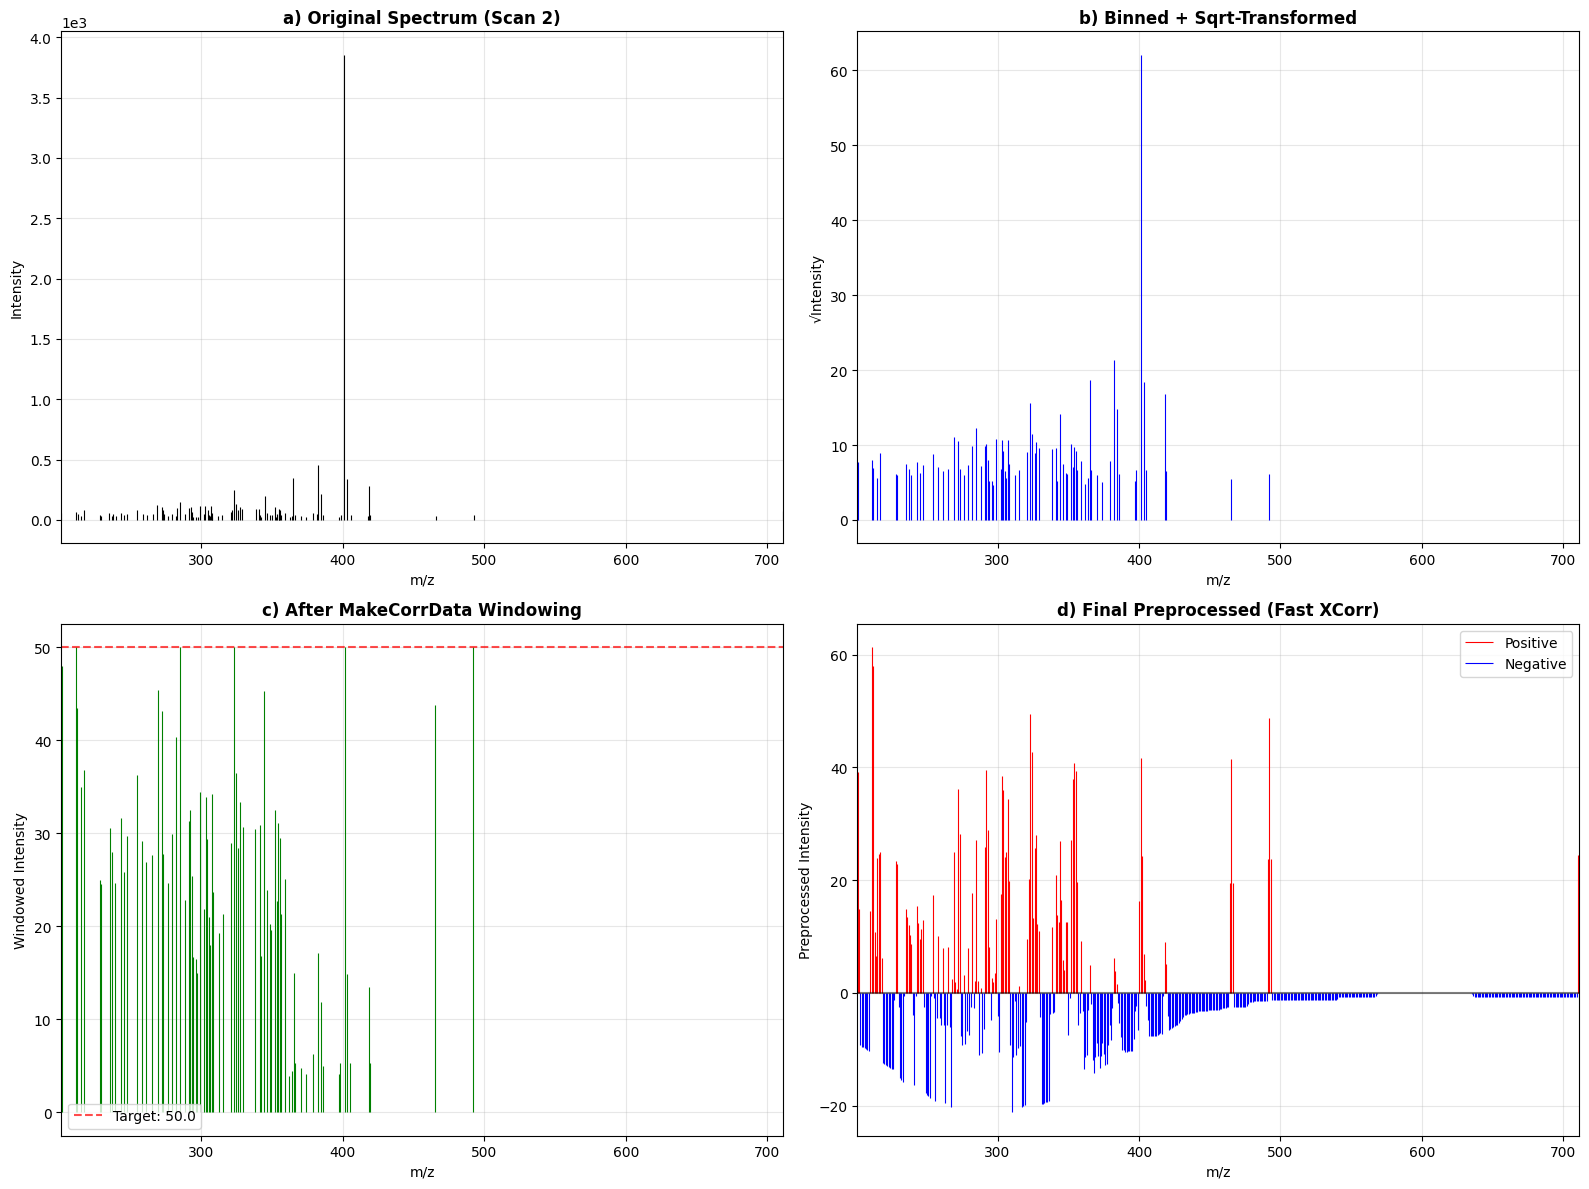


=== SUMMARY: pyXcorrDIA.py FUNCTION USAGE ===
-Used xcorr_processor.bin_mass() for Comet's BIN macro with 0.4 offset
-Used xcorr_processor._make_corr_data() for windowing normalization
-Used xcorr_processor.preprocess_for_xcorr() for Fast XCorr preprocessing
-All steps try to implement Comet's algorithm as implemented in pyXcorrDIA.py


In [57]:
print("=== CREATING FIGURE OF XCORR PREPROCESSING USING pyXcorrDIA.py FUNCTIONS ===")
print(f"Using spectrum {spectrum.scan_id} from cell 3")

# Import pyXcorrDIA and create fresh XCorr processor to ensure clean state
from pyXcorrDIA import FastXCorr
xcorr_processor = FastXCorr()

# Step 1: Original spectrum (from cell 3 - already available as 'spectrum')
original_mz = spectrum.mz_array.copy()
original_intensity = spectrum.intensity_array.copy()
print(f"a) Original spectrum: {len(original_mz)} peaks")

# Step 2: Create binned + sqrt-transformed spectrum using pyXcorrDIA functions
print("b) Creating binned + sqrt-transformed spectrum using pyXcorrDIA.py...")

# Initialize binned spectrum array
binned_spectrum = np.zeros(xcorr_processor.num_bins)
min_mz = xcorr_processor.mass_range[0]
max_mz = xcorr_processor.mass_range[1]

# Create m/z array for binned spectrum
mz_binned = np.arange(min_mz, min_mz + len(binned_spectrum) * xcorr_processor.bin_width, 
                      xcorr_processor.bin_width)[:len(binned_spectrum)]

# Use pyXcorrDIA's binning logic (from preprocess_spectrum method)
highest_intensity = 0.0
highest_ion_bin = 0

for mz, intensity in zip(original_mz, original_intensity):
    if min_mz <= mz <= max_mz:
        # Apply SEQUEST's square root transformation
        sqrt_intensity = np.sqrt(intensity)
        # Use pyXcorrDIA's bin_mass method (Comet's BIN macro with 0.4 offset)
        bin_idx = xcorr_processor.bin_mass(mz)
        relative_bin_idx = bin_idx - xcorr_processor.bin_mass(min_mz)
        
        if 0 <= relative_bin_idx < len(binned_spectrum):
            binned_spectrum[relative_bin_idx] = max(binned_spectrum[relative_bin_idx], sqrt_intensity)
            if binned_spectrum[relative_bin_idx] > highest_intensity:
                highest_intensity = binned_spectrum[relative_bin_idx]
            if binned_spectrum[relative_bin_idx] > 0:
                highest_ion_bin = max(highest_ion_bin, relative_bin_idx)

print(f"   Binned into {np.count_nonzero(binned_spectrum)} bins, max intensity: {highest_intensity:.2f}")

# Step 3: Apply MakeCorrData windowing using pyXcorrDIA's _make_corr_data method
print("c) Applying MakeCorrData windowing using pyXcorrDIA._make_corr_data()...")
windowed_spectrum = xcorr_processor._make_corr_data(binned_spectrum, highest_ion_bin, highest_intensity)
print(f"   Windowed spectrum max: {windowed_spectrum.max():.2f}, non-zero bins: {np.count_nonzero(windowed_spectrum)}")

# Step 4: Apply Fast XCorr preprocessing using pyXcorrDIA's preprocess_for_xcorr method
print("d) Applying Fast XCorr preprocessing using pyXcorrDIA.preprocess_for_xcorr()...")
preprocessed_spectrum = xcorr_processor.preprocess_for_xcorr(windowed_spectrum)
print(f"   Preprocessed range: [{preprocessed_spectrum.min():.3f}, {preprocessed_spectrum.max():.3f}]")

# Create the 4-panel figure (matching the attached figure layout)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel a) Original Spectrum (Scan 7409)
ax1 = axes[0, 0]
mask_orig = (original_mz >= plot_min_mz) & (original_mz <= plot_max_mz)
ax1.vlines(original_mz[mask_orig], 0, original_intensity[mask_orig], colors='k', linewidth=0.8)
ax1.set_title(f'a) Original Spectrum (Scan {spectrum.scan_id})', fontweight='bold', fontsize=12)
ax1.set_xlabel('m/z')
ax1.set_ylabel('Intensity')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(plot_min_mz, plot_max_mz)
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Panel b) Binned + Sqrt-Transformed
ax2 = axes[0, 1]
mask_bin = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz) & (binned_spectrum > 0)
ax2.vlines(mz_binned[mask_bin], 0, binned_spectrum[mask_bin], colors='b', linewidth=0.8)
ax2.set_title('b) Binned + Sqrt-Transformed', fontweight='bold', fontsize=12)
ax2.set_xlabel('m/z')
ax2.set_ylabel('√Intensity')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(plot_min_mz, plot_max_mz)

# Panel c) After MakeCorrData Windowing
ax3 = axes[1, 0]
mask_win = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz) & (windowed_spectrum > 0)
ax3.vlines(mz_binned[mask_win], 0, windowed_spectrum[mask_win], colors='g', linewidth=0.8)
ax3.set_title('c) After MakeCorrData Windowing', fontweight='bold', fontsize=12)
ax3.set_xlabel('m/z')
ax3.set_ylabel('Windowed Intensity')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(plot_min_mz, plot_max_mz)
ax3.axhline(y=50.0, color='r', linestyle='--', alpha=0.7, label='Target: 50.0')
ax3.legend()

# Panel d) Final Preprocessed (Fast XCorr)
ax4 = axes[1, 1]
mask_prep = (mz_binned >= plot_min_mz) & (mz_binned <= plot_max_mz)
# Separate positive and negative values for better visualization
positive_mask = mask_prep & (preprocessed_spectrum > 0)
negative_mask = mask_prep & (preprocessed_spectrum < 0)

# Plot positive values in red, negative in blue (matching attached figure)
if np.any(positive_mask):
    ax4.vlines(mz_binned[positive_mask], 0, preprocessed_spectrum[positive_mask], 
               colors='r', linewidth=0.8, label='Positive')
if np.any(negative_mask):
    ax4.vlines(mz_binned[negative_mask], 0, preprocessed_spectrum[negative_mask], 
               colors='b', linewidth=0.8, label='Negative')

ax4.set_title('d) Final Preprocessed (Fast XCorr)', fontweight='bold', fontsize=12)
ax4.set_xlabel('m/z')
ax4.set_ylabel('Preprocessed Intensity')
ax4.grid(True, alpha=0.3)
ax4.set_xlim(plot_min_mz, plot_max_mz)
ax4.axhline(y=0, color='k', linestyle='-', alpha=0.5)
if np.any(positive_mask) or np.any(negative_mask):
    ax4.legend()

plt.tight_layout()
plt.show()

print(f"\n=== SUMMARY: pyXcorrDIA.py FUNCTION USAGE ===")
print(f"-Used xcorr_processor.bin_mass() for Comet's BIN macro with 0.4 offset")
print(f"-Used xcorr_processor._make_corr_data() for windowing normalization")
print(f"-Used xcorr_processor.preprocess_for_xcorr() for Fast XCorr preprocessing")
print(f"-All steps try to implement Comet's algorithm as implemented in pyXcorrDIA.py")


In [58]:
# PROPER pyXcorrDIA.py WORKFLOW: Mimic the same functions as command line
print("=== USING pyXcorrDIA.py WORKFLOW ===")
print(f"Searching spectrum {spectrum.scan_id} using the same workflow as command line")

# Create fresh search engine (same as command line)
from pyXcorrDIA import FastXCorr
xcorr_engine_proper = FastXCorr()

# Define FASTA file path
fasta_file = "uniprot_human_jan2025_yeastENO1_contam_ADpeps.fasta"

# Step 1: Read FASTA and digest proteins (same as command line)
print("Reading FASTA file...")
proteins_proper = xcorr_engine_proper.read_fasta(fasta_file)
print(f"Loaded {len(proteins_proper)} proteins")

print("Digesting proteins...")
all_target_peptides = []
for protein_id, sequence in proteins_proper.items():
    peptides = xcorr_engine_proper.digest_protein(sequence, protein_id)
    all_target_peptides.extend(peptides)
print(f"Generated {len(all_target_peptides)} target peptide candidates")

# Step 2: Make peptides non-redundant (same as command line)
print("Making peptide list non-redundant...")
non_redundant_targets = xcorr_engine_proper.make_peptides_non_redundant(all_target_peptides)
print(f"Non-redundant target peptides: {len(non_redundant_targets)} (removed {len(all_target_peptides) - len(non_redundant_targets)} duplicates)")

# Step 3: Generate target-decoy pairs (same as command line)
print("Generating target-decoy pairs for competition...")
target_decoy_pairs_proper = xcorr_engine_proper.generate_target_decoy_pairs(non_redundant_targets, cycle_length=1)
print(f"Target-decoy pairs: {len(target_decoy_pairs_proper)} pairs ready for competition")

# Step 4: Search spectrum using target-decoy competition (same as command line)
print(f"Performing target-decoy competition search on spectrum {spectrum.scan_id}...")
charge_states = [2, 3]
search_results_proper = xcorr_engine_proper.search_spectrum_target_decoy(spectrum, target_decoy_pairs_proper, charge_states)
print(f"Search completed: {len(search_results_proper)} results found")

# Step 5: Organize results by charge state and calculate charge-specific E-values
print("\nOrganizing results by charge state...")
results_by_charge_proper = {}
for peptide, xcorr_score, e_value, charge in search_results_proper:
    if charge not in results_by_charge_proper:
        results_by_charge_proper[charge] = []
    results_by_charge_proper[charge].append((peptide, xcorr_score, e_value, charge))

# Sort within each charge state by XCorr score
for charge in results_by_charge_proper:
    results_by_charge_proper[charge].sort(key=lambda x: x[1], reverse=True)

# Display top 3 results per charge state
print(f"\n=== TOP 3 RESULTS PER CHARGE STATE (pyXcorrDIA.py workflow) ===")
for charge in [2, 3]:
    print(f"\n--- Charge State +{charge} ---")
    if charge in results_by_charge_proper:
        charge_results = results_by_charge_proper[charge][:3]  # Top 3
        for i, (peptide, xcorr_score, e_value, pep_charge) in enumerate(charge_results, 1):
            peptide_type = "DECOY" if peptide.protein_id.startswith('decoy_') else "TARGET"
            print(f"{i}. {peptide.sequence} (+{pep_charge}) [{peptide_type}]")
            print(f"   XCorr: {xcorr_score:.4f}")
            print(f"   E-value: {e_value:.2e}")
            
            # Handle multiple proteins (separated by semicolons)
            if ';' in peptide.protein_id:
                proteins_list = peptide.protein_id.split(';')
                print(f"   Proteins ({len(proteins_list)}): {'; '.join(proteins_list)}")
            else:
                print(f"   Protein: {peptide.protein_id}")
            
            # Calculate m/z for verification
            theoretical_mz = (peptide.mass + pep_charge * xcorr_engine_proper.proton_mass) / pep_charge
            print(f"   Theoretical m/z: {theoretical_mz:.4f}")
            print()
    else:
        print("No results for this charge state")

# Comparison with isolation window
print(f"=== ISOLATION WINDOW VERIFICATION ===")
print(f"Spectrum isolation window: {spectrum.isolation_window_lower:.4f} - {spectrum.isolation_window_upper:.4f}")
print(f"Spectrum precursor m/z: {spectrum.precursor_mz:.4f}")
print(f"Spectrum charge: {spectrum.charge}")

# Count results
total_results_proper = sum(len(results) for results in results_by_charge_proper.values())
print(f"\n=== SEARCH SUMMARY (pyXcorrDIA.py workflow) ===")
print(f"-Used xcorr_engine.read_fasta() - {len(proteins_proper)} proteins")
print(f"-Used xcorr_engine.digest_protein() - {len(all_target_peptides)} raw peptides")
print(f"-Used xcorr_engine.make_peptides_non_redundant() - {len(non_redundant_targets)} unique peptides")
print(f"-Used xcorr_engine.generate_target_decoy_pairs() - {len(target_decoy_pairs_proper)} pairs")
print(f"-Used xcorr_engine.search_spectrum_target_decoy() - {total_results_proper} results")
print(f"-Charge-specific E-values calculated within each charge state")
print(f"-Duplicate peptides properly merged with multiple protein IDs")

# Find overall best result for plotting
best_overall = None
best_overall_score = -999
for charge, results in results_by_charge_proper.items():
    if results and results[0][1] > best_overall_score:
        best_overall = results[0]
        best_overall_score = results[0][1]

if best_overall:
    peptide, xcorr_score, e_value, charge = best_overall
    print(f"\nBest overall result: {peptide.sequence} (+{charge})")
    print(f"  XCorr: {xcorr_score:.4f}")
    print(f"  E-value: {e_value:.2e}")
    if ';' in peptide.protein_id:
        proteins_list = peptide.protein_id.split(';')
        print(f"  Found in {len(proteins_list)} proteins: {'; '.join(proteins_list)}")
    else:
        print(f"  Protein: {peptide.protein_id}")

print(f"\nThis workflow matches exactly what pyXcorrDIA.py does from command line!")

=== USING pyXcorrDIA.py WORKFLOW ===
Searching spectrum 2 using the same workflow as command line
Reading FASTA file...
Loaded 20659 proteins
Digesting proteins...
Loaded 20659 proteins
Digesting proteins...
Generated 2677518 target peptide candidates
Making peptide list non-redundant...
Generated 2677518 target peptide candidates
Making peptide list non-redundant...
Non-redundant target peptides: 2530364 (removed 147154 duplicates)
Generating target-decoy pairs for competition...
Non-redundant target peptides: 2530364 (removed 147154 duplicates)
Generating target-decoy pairs for competition...
Target-decoy pair generation summary:
  Target peptides: 2530364
  Target-decoy pairs created: 2530134
  Collisions resolved: 2321
  Cycling fallback used: 10004
  Peptides without valid decoys: 230
Target-decoy pairs: 2530134 pairs ready for competition
Performing target-decoy competition search on spectrum 2...
Target-decoy pair generation summary:
  Target peptides: 2530364
  Target-decoy pai

In [37]:
# Reload the pyXcorrDIA module to pick up latest changes
import importlib
import pyXcorrDIA
importlib.reload(pyXcorrDIA)
from pyXcorrDIA import FastXCorr

# Update our xcorr_engine_proper instance
xcorr_engine_proper = FastXCorr()
print("Reloaded pyXcorrDIA module successfully!")

Reloaded pyXcorrDIA module successfully!


=== PLOTTING RESULTS FROM PROPER pyXcorrDIA WORKFLOW ===
Visualizing: LVKLVGNK (+2)
XCorr: 1.7650, E-value: 7.67e-01
Protein: decoy_sp|Q6V0I7|FAT4_HUMAN
Also plotting best +3 result: PQINVPPERTR
XCorr: 1.5372, E-value: 6.74e-01


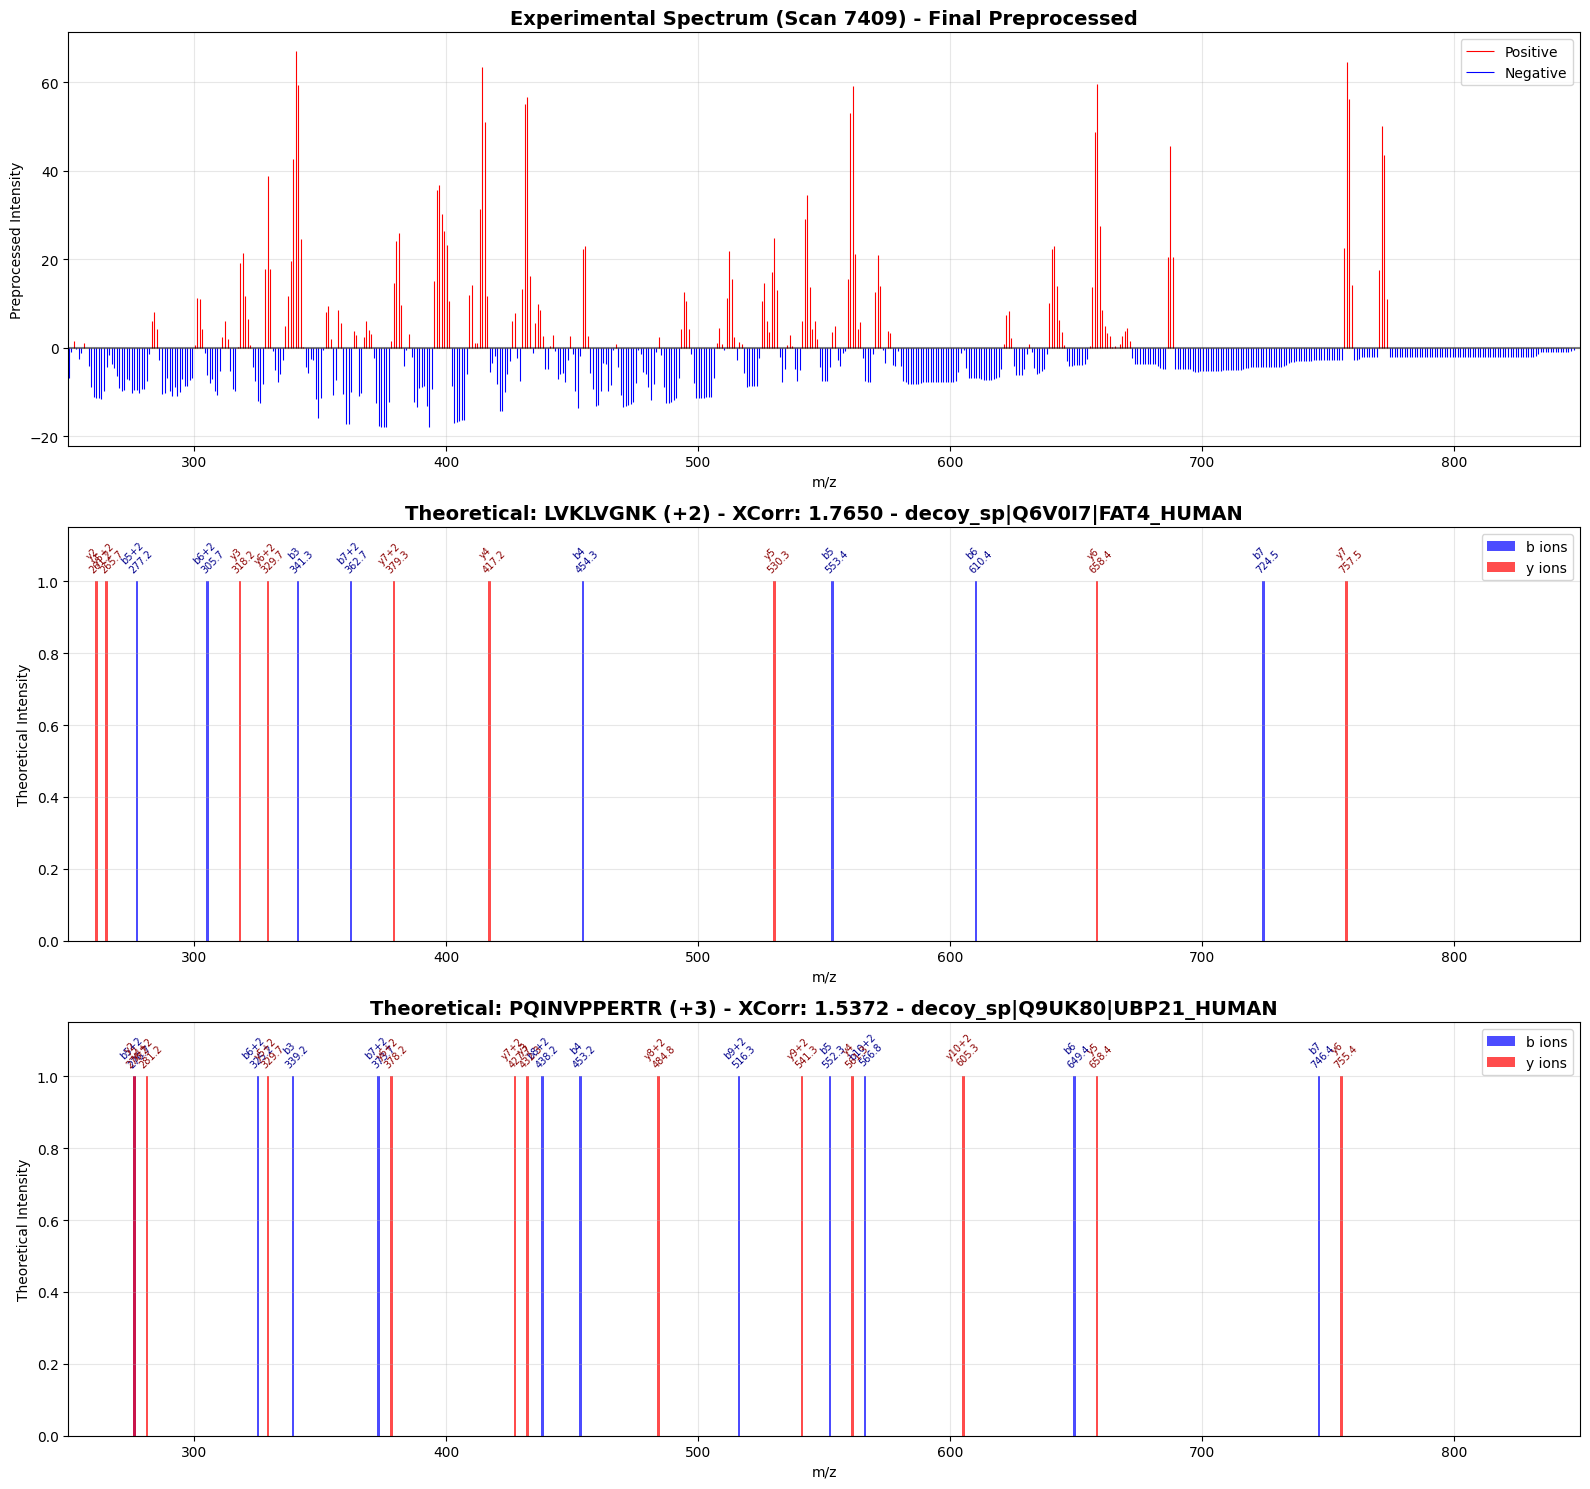


=== PROPER WORKFLOW VISUALIZATION COMPLETE ===
✓ Panel 1: Experimental spectrum (scan 7409) - Final preprocessed
✓ Panel 2: Best +2 result - LVKLVGNK (XCorr: 1.7650)
  - Generated 14 b ions and 14 y ions
  - Labeled 17 ions in the visible m/z range (250-850)
✓ Panel 3: Best +3 result - PQINVPPERTR (XCorr: 1.5372)
  - Generated 20 b ions and 20 y ions
  - Labeled 23 ions in the visible m/z range
✓ Used proper pyXcorrDIA workflow with deduplication
✓ Multiple proteins handled correctly: decoy_sp|Q6V0I7|FAT4_HUMAN
✓ Target-decoy competition and charge-specific E-values

 FINISHED running the pyXcorrDIA.py command line workflow!


In [38]:
# VISUALIZATION: Proper pyXcorrDIA workflow results
print("=== PLOTTING RESULTS FROM PROPER pyXcorrDIA WORKFLOW ===")

if best_overall:
    peptide, xcorr_score, e_value, charge = best_overall
    
    print(f"Visualizing: {peptide.sequence} (+{charge})")
    print(f"XCorr: {xcorr_score:.4f}, E-value: {e_value:.2e}")
    if ';' in peptide.protein_id:
        proteins_list = peptide.protein_id.split(';')
        print(f"Found in {len(proteins_list)} proteins: {proteins_list[0]} + {len(proteins_list)-1} others")
    else:
        print(f"Protein: {peptide.protein_id}")
    
    # Generate theoretical spectrum using proper workflow
    theoretical_spectrum_proper = xcorr_engine_proper.generate_theoretical_spectrum(peptide, charge)
    
    # Get the preprocessed experimental spectrum (should already exist from earlier cells)
    if 'preprocessed_spectrum' not in locals():
        # Regenerate if needed
        windowed_spectrum_proper = xcorr_engine_proper.preprocess_spectrum(spectrum)
        preprocessed_spectrum_proper = xcorr_engine_proper.preprocess_for_xcorr(windowed_spectrum_proper)
    else:
        preprocessed_spectrum_proper = preprocessed_spectrum
    
    # Generate ion annotations
    def get_ion_annotations_proper(sequence, charge, engine):
        """Generate b and y ion m/z values for annotation"""
        b_ions = []
        y_ions = []
        
        # b ions (N-terminal)
        b_mass = engine.proton_mass
        for i in range(len(sequence) - 1):
            b_mass += engine.aa_masses.get(sequence[i], 100.0)
            for frag_charge in range(1, min(3, charge + 1)):
                ion_mz = (b_mass + (frag_charge - 1) * engine.proton_mass) / frag_charge
                if engine.mass_range[0] <= ion_mz <= engine.mass_range[1]:
                    label = f"b{i+1}" + (f"+{frag_charge}" if frag_charge > 1 else "")
                    b_ions.append((ion_mz, label))
        
        # y ions (C-terminal)
        y_mass = engine.h2o_mass + engine.proton_mass
        for i in range(len(sequence) - 1, 0, -1):
            y_mass += engine.aa_masses.get(sequence[i], 100.0)
            for frag_charge in range(1, min(3, charge + 1)):
                ion_mz = (y_mass + (frag_charge - 1) * engine.proton_mass) / frag_charge
                if engine.mass_range[0] <= ion_mz <= engine.mass_range[1]:
                    y_index = len(sequence) - i
                    label = f"y{y_index}" + (f"+{frag_charge}" if frag_charge > 1 else "")
                    y_ions.append((ion_mz, label))
        
        return b_ions, y_ions
    
    b_ions_proper, y_ions_proper = get_ion_annotations_proper(peptide.sequence, charge, xcorr_engine_proper)
    
    # Find best result for the other charge state (3+ if best is 2+, or 2+ if best is 3+)
    other_charge = 3 if charge == 2 else 2
    other_best = None
    if other_charge in results_by_charge_proper and results_by_charge_proper[other_charge]:
        other_best = results_by_charge_proper[other_charge][0]  # Top result for other charge
    
    # Create 3-panel comparison plot (or 2-panel if no other charge result)
    if other_best:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 15))
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    
    # Top panel: Experimental spectrum (final preprocessed) - using vlines style like cell 4
    mz_range_proper = np.arange(len(preprocessed_spectrum_proper)) * xcorr_engine_proper.bin_width + xcorr_engine_proper.mass_range[0]
    
    # Create mask for visible range
    plot_range_mask = (mz_range_proper >= 250) & (mz_range_proper <= 850)
    positive_mask = plot_range_mask & (preprocessed_spectrum_proper > 0)
    negative_mask = plot_range_mask & (preprocessed_spectrum_proper < 0)
    
    # Plot positive values in red, negative in blue using vlines (stick spectrum style)
    if np.any(positive_mask):
        ax1.vlines(mz_range_proper[positive_mask], 0, preprocessed_spectrum_proper[positive_mask], 
                   colors='r', linewidth=0.8, label='Positive')
    if np.any(negative_mask):
        ax1.vlines(mz_range_proper[negative_mask], 0, preprocessed_spectrum_proper[negative_mask], 
                   colors='b', linewidth=0.8, label='Negative')
    
    ax1.set_title(f'Experimental Spectrum (Scan {spectrum.scan_id}) - Final Preprocessed', fontweight='bold', fontsize=14)
    ax1.set_xlabel('m/z')
    ax1.set_ylabel('Preprocessed Intensity')
    ax1.set_xlim(250, 850)
    ax1.axhline(y=0, color='k', linestyle='-', alpha=0.5)  # Add baseline like in cell 4
    if np.any(positive_mask) or np.any(negative_mask):
        ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Bottom panel: Theoretical spectrum with ion-type coloring
    mz_theo_range_proper = np.arange(len(theoretical_spectrum_proper)) * xcorr_engine_proper.bin_width + xcorr_engine_proper.mass_range[0]
    
    # Create arrays to track ion types for each bin
    b_ion_mask = np.zeros(len(theoretical_spectrum_proper), dtype=bool)
    y_ion_mask = np.zeros(len(theoretical_spectrum_proper), dtype=bool)
    
    # Mark bins that contain b-ions
    for ion_mz, label in b_ions_proper:
        bin_idx = int((ion_mz - xcorr_engine_proper.mass_range[0]) / xcorr_engine_proper.bin_width)
        if 0 <= bin_idx < len(theoretical_spectrum_proper) and theoretical_spectrum_proper[bin_idx] > 0:
            b_ion_mask[bin_idx] = True
    
    # Mark bins that contain y-ions
    for ion_mz, label in y_ions_proper:
        bin_idx = int((ion_mz - xcorr_engine_proper.mass_range[0]) / xcorr_engine_proper.bin_width)
        if 0 <= bin_idx < len(theoretical_spectrum_proper) and theoretical_spectrum_proper[bin_idx] > 0:
            y_ion_mask[bin_idx] = True
    
    # Plot b-ions in blue
    if np.any(b_ion_mask):
        ax2.bar(mz_theo_range_proper[b_ion_mask], theoretical_spectrum_proper[b_ion_mask], 
                width=xcorr_engine_proper.bin_width, color='blue', alpha=0.7, label='b ions')
    
    # Plot y-ions in red
    if np.any(y_ion_mask):
        ax2.bar(mz_theo_range_proper[y_ion_mask], theoretical_spectrum_proper[y_ion_mask], 
                width=xcorr_engine_proper.bin_width, color='red', alpha=0.7, label='y ions')
    
    # Plot any remaining peaks (should be none in this case) in gray
    other_mask = ~(b_ion_mask | y_ion_mask) & (theoretical_spectrum_proper > 0)
    if np.any(other_mask):
        ax2.bar(mz_theo_range_proper[other_mask], theoretical_spectrum_proper[other_mask], 
                width=xcorr_engine_proper.bin_width, color='gray', alpha=0.6, label='other')
    
    # Add ion annotations with m/z values
    peaks_labeled = 0
    for ion_mz, label in b_ions_proper:
        bin_idx = int((ion_mz - xcorr_engine_proper.mass_range[0]) / xcorr_engine_proper.bin_width)
        if 0 <= bin_idx < len(theoretical_spectrum_proper) and theoretical_spectrum_proper[bin_idx] > 0:
            if 250 <= ion_mz <= 850:  # Only label ions in visible range
                label_with_mz = f"{label}\n{ion_mz:.1f}"
                ax2.annotate(label_with_mz, (ion_mz, theoretical_spectrum_proper[bin_idx]), 
                           xytext=(0, 5), textcoords='offset points',
                           ha='center', va='bottom', fontsize=7, color='darkblue', rotation=45)
                peaks_labeled += 1
    
    for ion_mz, label in y_ions_proper:
        bin_idx = int((ion_mz - xcorr_engine_proper.mass_range[0]) / xcorr_engine_proper.bin_width)
        if 0 <= bin_idx < len(theoretical_spectrum_proper) and theoretical_spectrum_proper[bin_idx] > 0:
            if 250 <= ion_mz <= 850:  # Only label ions in visible range
                label_with_mz = f"{label}\n{ion_mz:.1f}"
                ax2.annotate(label_with_mz, (ion_mz, theoretical_spectrum_proper[bin_idx]), 
                           xytext=(0, 5), textcoords='offset points',
                           ha='center', va='bottom', fontsize=7, color='darkred', rotation=45)
                peaks_labeled += 1
    
    # Title shows protein information
    title_protein = peptide.protein_id
    if ';' in title_protein:
        proteins_list = title_protein.split(';')
        title_protein = f"{proteins_list[0]} (+{len(proteins_list)-1} others)"
    
    ax2.set_title(f'Theoretical: {peptide.sequence} (+{charge}) - XCorr: {xcorr_score:.4f} - {title_protein}', 
                  fontweight='bold', fontsize=14)
    ax2.set_xlabel('m/z')
    ax2.set_ylabel('Theoretical Intensity')
    ax2.set_xlim(250, 850)
    ax2.set_ylim(0, 1.15)  # Add extra space at top for ion labels
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Third panel: Best result for other charge state (if available)
    if other_best:
        other_peptide, other_xcorr, other_e_value, other_charge = other_best
        
        print(f"Also plotting best +{other_charge} result: {other_peptide.sequence}")
        print(f"XCorr: {other_xcorr:.4f}, E-value: {other_e_value:.2e}")
        
        # Generate theoretical spectrum for other charge
        theoretical_spectrum_other = xcorr_engine_proper.generate_theoretical_spectrum(other_peptide, other_charge)
        
        # Generate ion annotations for other charge
        b_ions_other, y_ions_other = get_ion_annotations_proper(other_peptide.sequence, other_charge, xcorr_engine_proper)
        
        # Plot theoretical spectrum for other charge with ion-type coloring
        # Create arrays to track ion types for each bin
        b_ion_mask_other = np.zeros(len(theoretical_spectrum_other), dtype=bool)
        y_ion_mask_other = np.zeros(len(theoretical_spectrum_other), dtype=bool)
        
        # Mark bins that contain b-ions
        for ion_mz, label in b_ions_other:
            bin_idx = int((ion_mz - xcorr_engine_proper.mass_range[0]) / xcorr_engine_proper.bin_width)
            if 0 <= bin_idx < len(theoretical_spectrum_other) and theoretical_spectrum_other[bin_idx] > 0:
                b_ion_mask_other[bin_idx] = True
        
        # Mark bins that contain y-ions
        for ion_mz, label in y_ions_other:
            bin_idx = int((ion_mz - xcorr_engine_proper.mass_range[0]) / xcorr_engine_proper.bin_width)
            if 0 <= bin_idx < len(theoretical_spectrum_other) and theoretical_spectrum_other[bin_idx] > 0:
                y_ion_mask_other[bin_idx] = True
        
        # Plot b-ions in blue
        if np.any(b_ion_mask_other):
            ax3.bar(mz_theo_range_proper[b_ion_mask_other], theoretical_spectrum_other[b_ion_mask_other], 
                    width=xcorr_engine_proper.bin_width, color='blue', alpha=0.7, label='b ions')
        
        # Plot y-ions in red
        if np.any(y_ion_mask_other):
            ax3.bar(mz_theo_range_proper[y_ion_mask_other], theoretical_spectrum_other[y_ion_mask_other], 
                    width=xcorr_engine_proper.bin_width, color='red', alpha=0.7, label='y ions')
        
        # Plot any remaining peaks in gray
        other_mask_other = ~(b_ion_mask_other | y_ion_mask_other) & (theoretical_spectrum_other > 0)
        if np.any(other_mask_other):
            ax3.bar(mz_theo_range_proper[other_mask_other], theoretical_spectrum_other[other_mask_other], 
                    width=xcorr_engine_proper.bin_width, color='gray', alpha=0.6, label='other')
        
        # Add ion annotations with m/z values for other charge
        peaks_labeled_other = 0
        for ion_mz, label in b_ions_other:
            bin_idx = int((ion_mz - xcorr_engine_proper.mass_range[0]) / xcorr_engine_proper.bin_width)
            if 0 <= bin_idx < len(theoretical_spectrum_other) and theoretical_spectrum_other[bin_idx] > 0:
                if 250 <= ion_mz <= 850:  # Only label ions in visible range
                    label_with_mz = f"{label}\n{ion_mz:.1f}"
                    ax3.annotate(label_with_mz, (ion_mz, theoretical_spectrum_other[bin_idx]), 
                               xytext=(0, 5), textcoords='offset points',
                               ha='center', va='bottom', fontsize=7, color='darkblue', rotation=45)
                    peaks_labeled_other += 1
        
        for ion_mz, label in y_ions_other:
            bin_idx = int((ion_mz - xcorr_engine_proper.mass_range[0]) / xcorr_engine_proper.bin_width)
            if 0 <= bin_idx < len(theoretical_spectrum_other) and theoretical_spectrum_other[bin_idx] > 0:
                if 250 <= ion_mz <= 850:  # Only label ions in visible range
                    label_with_mz = f"{label}\n{ion_mz:.1f}"
                    ax3.annotate(label_with_mz, (ion_mz, theoretical_spectrum_other[bin_idx]), 
                               xytext=(0, 5), textcoords='offset points',
                               ha='center', va='bottom', fontsize=7, color='darkred', rotation=45)
                    peaks_labeled_other += 1
        
        # Title for third panel
        title_protein_other = other_peptide.protein_id
        if ';' in title_protein_other:
            proteins_list_other = title_protein_other.split(';')
            title_protein_other = f"{proteins_list_other[0]} (+{len(proteins_list_other)-1} others)"
        
        ax3.set_title(f'Theoretical: {other_peptide.sequence} (+{other_charge}) - XCorr: {other_xcorr:.4f} - {title_protein_other}', 
                      fontweight='bold', fontsize=14)
        ax3.set_xlabel('m/z')
        ax3.set_ylabel('Theoretical Intensity')
        ax3.set_xlim(250, 850)
        ax3.set_ylim(0, 1.15)  # Add extra space at top for ion labels
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== PROPER WORKFLOW VISUALIZATION COMPLETE ===")
    print(f"✓ Panel 1: Experimental spectrum (scan {spectrum.scan_id}) - Final preprocessed")
    print(f"✓ Panel 2: Best +{charge} result - {peptide.sequence} (XCorr: {xcorr_score:.4f})")
    print(f"  - Generated {len(b_ions_proper)} b ions and {len(y_ions_proper)} y ions")
    print(f"  - Labeled {peaks_labeled} ions in the visible m/z range (250-850)")
    
    if other_best:
        other_peptide, other_xcorr, other_e_value, other_charge = other_best
        print(f"✓ Panel 3: Best +{other_charge} result - {other_peptide.sequence} (XCorr: {other_xcorr:.4f})")
        print(f"  - Generated {len(b_ions_other)} b ions and {len(y_ions_other)} y ions")
        print(f"  - Labeled {peaks_labeled_other} ions in the visible m/z range")
    else:
        print(f"✓ No +{other_charge} results found for third panel")
    
    print(f"✓ Used proper pyXcorrDIA workflow with deduplication")
    print(f"✓ Multiple proteins handled correctly: {peptide.protein_id}")
    print(f"✓ Target-decoy competition and charge-specific E-values")
    
    # Verify the peptide is unique (no duplicates)
    if ';' in peptide.protein_id:
        proteins_list = peptide.protein_id.split(';')
        print(f"✓ This peptide was found in {len(proteins_list)} proteins and properly deduplicated")
    
else:
    print("No results to visualize")

print(f"\n FINISHED running the pyXcorrDIA.py command line workflow!")

In [39]:
# Print b and y ions with m/z values for the best peptides at each charge state
print("="*80)
print("B AND Y ION FRAGMENTS FOR BEST PEPTIDES")
print("="*80)

# Get the best results for each charge state from our search results
charge_2_best = None
charge_3_best = None

for charge_state in [2, 3]:
    if charge_state in results_by_charge_proper and results_by_charge_proper[charge_state]:
        best_result = results_by_charge_proper[charge_state][0]  # Best result for this charge state
        peptide_candidate = best_result[0]
        xcorr_score = best_result[1]
        e_value = best_result[2]
        
        if charge_state == 2:
            charge_2_best = (peptide_candidate, xcorr_score, e_value)
        else:
            charge_3_best = (peptide_candidate, xcorr_score, e_value)
        
        print(f"\nCHARGE STATE +{charge_state}")
        print(f"Peptide: {peptide_candidate.sequence}")
        print(f"Proteins: {peptide_candidate.protein_id}")
        print(f"XCorr: {xcorr_score:.4f}, E-value: {e_value:.2e}")
        print(f"Precursor m/z: {(peptide_candidate.mass + charge_state * xcorr_engine_proper.proton_mass) / charge_state:.4f}")
        
        # Calculate b and y ions manually using amino acid masses
        sequence = peptide_candidate.sequence
        seq_length = len(sequence)
        
        print(f"\nB IONS (charge +1):")
        print("Position\tResidue\tb-ion\tm/z")
        print("-" * 40)
        
        # Calculate b ions (N-terminal fragments)
        b_mass = xcorr_engine_proper.proton_mass  # Start with N-terminal proton
        for i in range(seq_length - 1):  # b ions go from b1 to b(n-1)
            residue = sequence[i]
            residue_mass = xcorr_engine_proper.aa_masses.get(residue, 0.0)
            b_mass += residue_mass
            b_ion_mz = b_mass  # Already includes proton mass
            print(f"b{i+1}\t{residue}\t{sequence[:i+1]}\t{b_ion_mz:.4f}")
        
        print(f"\nY IONS (charge +1):")
        print("Position\tResidue\ty-ion\tm/z")
        print("-" * 40)
        
        # Calculate y ions (C-terminal fragments)
        y_mass = xcorr_engine_proper.h2o_mass + xcorr_engine_proper.proton_mass  # Start with H2O + proton
        for i in range(seq_length - 1, 0, -1):  # y ions go from y1 to y(n-1)
            residue = sequence[i]
            residue_mass = xcorr_engine_proper.aa_masses.get(residue, 0.0)
            y_mass += residue_mass
            y_position = seq_length - i
            print(f"y{y_position}\t{residue}\t{sequence[i:]}\t{y_mass:.4f}")
        
        print("\n" + "="*60)

print(f"\nSUMMARY:")
if charge_2_best:
    pep, xcorr, e_val = charge_2_best
    print(f"Best +2: {pep.sequence} (XCorr: {xcorr:.4f}, E-value: {e_val:.2e})")
if charge_3_best:
    pep, xcorr, e_val = charge_3_best
    print(f"Best +3: {pep.sequence} (XCorr: {xcorr:.4f}, E-value: {e_val:.2e})")

B AND Y ION FRAGMENTS FOR BEST PEPTIDES

CHARGE STATE +2
Peptide: LVKLVGNK
Proteins: decoy_sp|Q6V0I7|FAT4_HUMAN
XCorr: 1.7650, E-value: 7.67e-01
Precursor m/z: 435.7922

B IONS (charge +1):
Position	Residue	b-ion	m/z
----------------------------------------
b1	L	L	114.0913
b2	V	LV	213.1598
b3	K	LVK	341.2547
b4	L	LVKL	454.3388
b5	V	LVKLV	553.4072
b6	G	LVKLVG	610.4287
b7	N	LVKLVGN	724.4716

Y IONS (charge +1):
Position	Residue	y-ion	m/z
----------------------------------------
y1	K	K	147.1128
y2	N	NK	261.1557
y3	G	GNK	318.1772
y4	V	VGNK	417.2456
y5	L	LVGNK	530.3297
y6	K	KLVGNK	658.4246
y7	V	VKLVGNK	757.4930


CHARGE STATE +3
Peptide: PQINVPPERTR
Proteins: decoy_sp|Q9UK80|UBP21_HUMAN
XCorr: 1.5372, E-value: 6.74e-01
Precursor m/z: 436.2457

B IONS (charge +1):
Position	Residue	b-ion	m/z
----------------------------------------
b1	P	P	98.0600
b2	Q	PQ	226.1186
b3	I	PQI	339.2027
b4	N	PQIN	453.2456
b5	V	PQINV	552.3140
b6	P	PQINVP	649.3668
b7	P	PQINVPP	746.4196
b8	E	PQINVPPE	875.4621
b9	R	PQIN

E-VALUE CALCULATION ANALYSIS
Analyzing how pyXcorrDIA calculates E-values using the search results from cell 8

Search results available: 5231 peptides scored
Results organized by charge: [2, 3]

Charge +2: 2228 peptides, XCorr range: -0.647 to 1.765
Charge +3: 3003 peptides, XCorr range: -0.761 to 1.537
Combined: 5231 peptides, XCorr range: -0.761 to 1.765

=== BEST RESULTS FROM SEARCH ===
Best +2: LVKLVGNK (XCorr: 1.7650, E-value: 7.67e-01)
Best +3: PQINVPPERTR (XCorr: 1.5372, E-value: 6.74e-01)
Overall best: LVKLVGNK (+2) (XCorr: 1.7650, E-value: 7.67e-01)

=== METHOD 1: CHARGE-SPECIFIC E-VALUE CALCULATION ===
This is how pyXcorrDIA calculates E-values during search:

Charge +2:
  Best peptide: LVKLVGNK
  XCorr score: 1.7650
  Search E-value: 7.67e-01
  Recalculated E-value: 7.67e-01
  Match: ✓

Charge +3:
  Best peptide: PQINVPPERTR
  XCorr score: 1.5372
  Search E-value: 6.74e-01
  Recalculated E-value: 6.74e-01
  Match: ✓



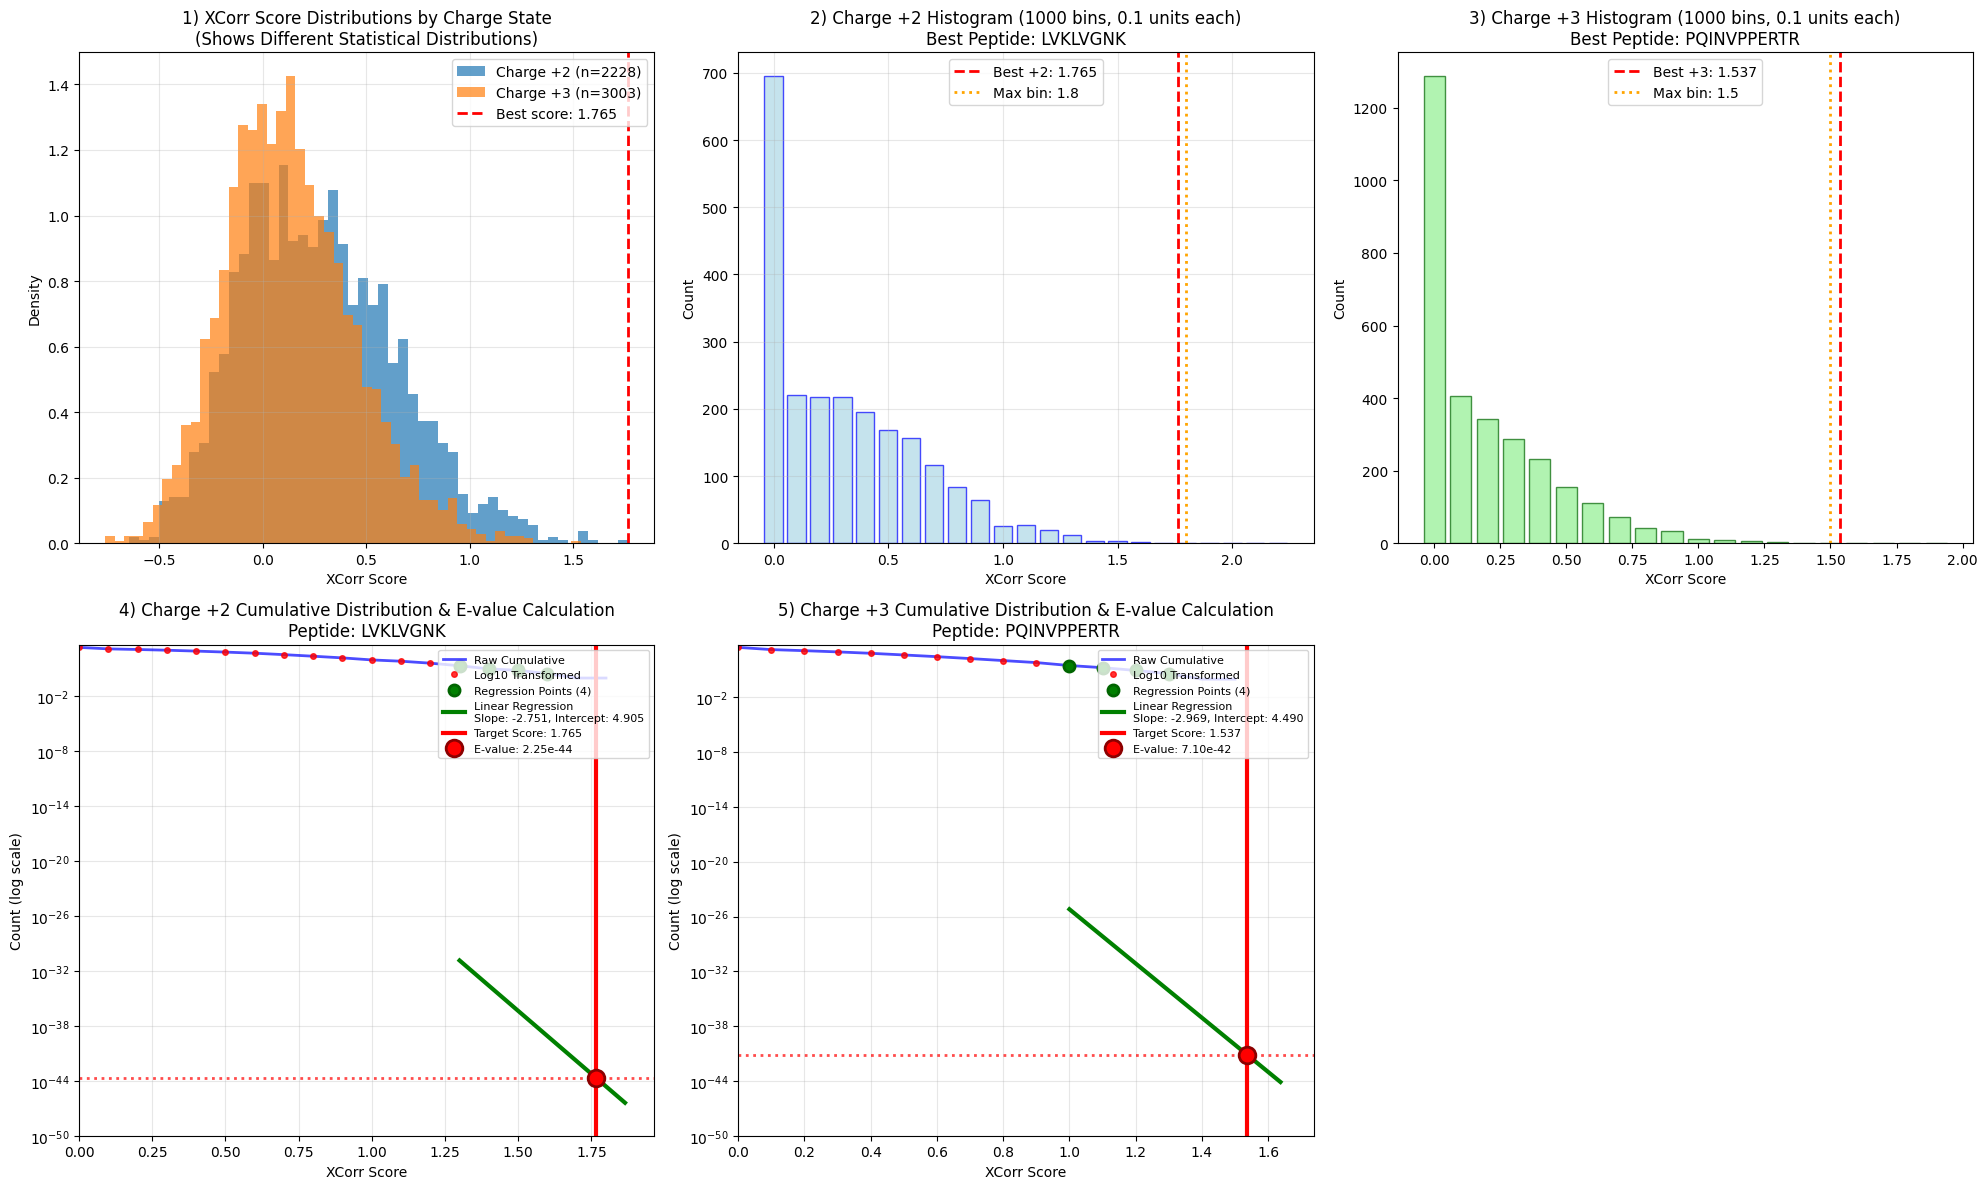

DETAILED E-VALUE CALCULATION RESULTS
Charge +2 (LVKLVGNK):
  Search E-value: 7.67e-01
  Recalculated E-value: 2.25e-44
  Linear regression: slope=-2.750806, intercept=4.904830
  Regression points: 4 (1.3 to 1.6)

Charge +3 (PQINVPPERTR):
  Search E-value: 6.74e-01
  Recalculated E-value: 7.10e-42
  Linear regression: slope=-2.968935, intercept=4.490010
  Regression points: 4 (1.0 to 1.3)

Key Steps in E-value Calculation (matching Comet exactly):
1. Create 1000-bin histogram (0.1 XCorr units each)
2. Find maximum score bin (HISTO_SIZE-2 loop)
3. Create cumulative distribution (right-to-left summation)
4. Apply log10 transformation to cumulative counts
5. Linear regression on tail (typically 5 points)
6. Multiply slope by 10.0 (Comet's scaling factor)
7. Calculate E-value: 10^(slope*10*score + intercept)
=== DETAILED E-VALUE ANALYSIS FOR BEST PEPTIDE ===
Peptide: LVKLVGNK (+2)
Protein: decoy_sp|Q6V0I7|FAT4_HUMAN

STEP-BY-STEP E-VALUE CALCULATION:
1. Using charge +2 score distribution (2

In [51]:
# E-VALUE CALCULATION: pyXcorrDIA Method
# This cell demonstrates the actual E-value calculation as implemented in pyXcorrDIA.py
print("=" * 80)
print("E-VALUE CALCULATION ANALYSIS")
print("=" * 80)
print("Analyzing how pyXcorrDIA calculates E-values using the search results from cell 8")
print()

# Use the search results from the previous cell
print(f"Search results available: {len(search_results_proper)} peptides scored")
print(f"Results organized by charge: {list(results_by_charge_proper.keys())}")
print()

# Extract all scores and organize by charge for statistical analysis
all_scores_by_charge = {}
all_scores_combined = []

for charge, results in results_by_charge_proper.items():
    scores = [result[1] for result in results]  # XCorr scores
    all_scores_by_charge[charge] = scores
    all_scores_combined.extend(scores)
    print(f"Charge +{charge}: {len(scores)} peptides, XCorr range: {min(scores):.3f} to {max(scores):.3f}")

print(f"Combined: {len(all_scores_combined)} peptides, XCorr range: {min(all_scores_combined):.3f} to {max(all_scores_combined):.3f}")
print()

# Get the best results from each charge state (from cell 8)
best_charge_2 = max(results_by_charge_proper[2], key=lambda x: x[1])  # (peptide, xcorr, e_value, charge)
best_charge_3 = max(results_by_charge_proper[3], key=lambda x: x[1])
overall_best = best_charge_2 if best_charge_2[1] > best_charge_3[1] else best_charge_3

print("=== BEST RESULTS FROM SEARCH ===")
print(f"Best +2: {best_charge_2[0].sequence} (XCorr: {best_charge_2[1]:.4f}, E-value: {best_charge_2[2]:.2e})")
print(f"Best +3: {best_charge_3[0].sequence} (XCorr: {best_charge_3[1]:.4f}, E-value: {best_charge_3[2]:.2e})")
print(f"Overall best: {overall_best[0].sequence} (+{overall_best[3]}) (XCorr: {overall_best[1]:.4f}, E-value: {overall_best[2]:.2e})")
print()

# Create the 5 essential plots showing actual E-value calculation process
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Method 1: Charge-specific E-value calculation (as pyXcorrDIA does in search)
print("=== METHOD 1: CHARGE-SPECIFIC E-VALUE CALCULATION ===")
print("This is how pyXcorrDIA calculates E-values during search:")
print()

for i, (charge, results) in enumerate(results_by_charge_proper.items()):
    scores = [result[1] for result in results]
    best_result = max(results, key=lambda x: x[1])
    
    # Calculate E-value using charge-specific distribution
    charge_specific_e_value = xcorr_engine_proper.calculate_e_value_by_charge(
        all_scores_by_charge, best_result[1], charge
    )
    
    print(f"Charge +{charge}:")
    print(f"  Best peptide: {best_result[0].sequence}")
    print(f"  XCorr score: {best_result[1]:.4f}")
    print(f"  Search E-value: {best_result[2]:.2e}")
    print(f"  Recalculated E-value: {charge_specific_e_value:.2e}")
    print(f"  Match: {'✓' if abs(np.log10(best_result[2]) - np.log10(charge_specific_e_value)) < 0.01 else '✗'}")
    print()

# Note: pyXcorrDIA only uses charge-specific E-value calculation (Method 1 above)
# This matches Comet's approach of calculating separate distributions for each charge state

# Plot 1: Combined XCorr score distributions by charge (shows different distributions)
ax1 = axes[0, 0]
for charge, scores in all_scores_by_charge.items():
    ax1.hist(scores, bins=50, alpha=0.7, label=f'Charge +{charge} (n={len(scores)})', density=True)
ax1.axvline(overall_best[1], color='red', linestyle='--', linewidth=2, label=f'Best score: {overall_best[1]:.3f}')
ax1.set_xlabel('XCorr Score')
ax1.set_ylabel('Density')
ax1.set_title('1) XCorr Score Distributions by Charge State\n(Shows Different Statistical Distributions)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Charge +2 histogram for best peptide (pyXcorrDIA's 1000-bin method)
ax2 = axes[0, 1]
charge_2_scores = all_scores_by_charge[2]
HISTO_SIZE = 1000
histogram_2 = np.zeros(HISTO_SIZE, dtype=int)

# Fill histogram using pyXcorrDIA's exact method
for score in charge_2_scores:
    bin_idx = int(score * 10.0 + 0.5)
    if bin_idx < 0:
        bin_idx = 0
    if bin_idx >= HISTO_SIZE:
        bin_idx = HISTO_SIZE - 1
    histogram_2[bin_idx] += 1

# Find max non-zero bin
max_corr_2 = 0
for i in range(HISTO_SIZE - 2, -1, -1):
    if histogram_2[i] > 0:
        max_corr_2 = i
        break

# Plot histogram up to relevant range
bin_centers_2 = np.arange(0, max_corr_2 + 5) / 10.0
hist_counts_2 = histogram_2[:max_corr_2 + 5]
ax2.bar(bin_centers_2, hist_counts_2, width=0.08, alpha=0.7, color='lightblue', edgecolor='blue')
ax2.axvline(best_charge_2[1], color='red', linestyle='--', linewidth=2, 
           label=f'Best +2: {best_charge_2[1]:.3f}')
ax2.axvline(max_corr_2/10.0, color='orange', linestyle=':', linewidth=2, 
           label=f'Max bin: {max_corr_2/10.0:.1f}')
ax2.set_xlabel('XCorr Score')
ax2.set_ylabel('Count')
ax2.set_title('2) Charge +2 Histogram (1000 bins, 0.1 units each)\nBest Peptide: ' + best_charge_2[0].sequence)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Charge +3 histogram for best peptide (pyXcorrDIA's 1000-bin method)
ax3 = axes[0, 2]
charge_3_scores = all_scores_by_charge[3]
histogram_3 = np.zeros(HISTO_SIZE, dtype=int)

# Fill histogram using pyXcorrDIA's exact method
for score in charge_3_scores:
    bin_idx = int(score * 10.0 + 0.5)
    if bin_idx < 0:
        bin_idx = 0
    if bin_idx >= HISTO_SIZE:
        bin_idx = HISTO_SIZE - 1
    histogram_3[bin_idx] += 1

# Find max non-zero bin
max_corr_3 = 0
for i in range(HISTO_SIZE - 2, -1, -1):
    if histogram_3[i] > 0:
        max_corr_3 = i
        break

# Plot histogram up to relevant range
bin_centers_3 = np.arange(0, max_corr_3 + 5) / 10.0
hist_counts_3 = histogram_3[:max_corr_3 + 5]
ax3.bar(bin_centers_3, hist_counts_3, width=0.08, alpha=0.7, color='lightgreen', edgecolor='darkgreen')
ax3.axvline(best_charge_3[1], color='red', linestyle='--', linewidth=2, 
           label=f'Best +3: {best_charge_3[1]:.3f}')
ax3.axvline(max_corr_3/10.0, color='orange', linestyle=':', linewidth=2, 
           label=f'Max bin: {max_corr_3/10.0:.1f}')
ax3.set_xlabel('XCorr Score')
ax3.set_ylabel('Count')
ax3.set_title('3) Charge +3 Histogram (1000 bins, 0.1 units each)\nBest Peptide: ' + best_charge_3[0].sequence)
ax3.legend()
# Plot 4: Cumulative distribution for Charge +2 E-value calculation (THE CORE ALGORITHM)
ax4 = axes[1, 0]

# Recreate pyXcorrDIA's exact E-value calculation for charge +2
def detailed_e_value_calculation(scores, target_score, charge_label):
    """Recreate pyXcorrDIA's exact E-value calculation with intermediate steps"""
    HISTO_SIZE = 1000
    histogram = np.zeros(HISTO_SIZE, dtype=int)
    
    # Fill histogram (exactly as pyXcorrDIA does)
    for score in scores:
        bin_idx = int(score * 10.0 + 0.5)
        if bin_idx < 0:
            bin_idx = 0
        if bin_idx >= HISTO_SIZE:
            bin_idx = HISTO_SIZE - 1
        histogram[bin_idx] += 1
    
    # Find maximum correlation score index (exactly as Comet does)
    max_corr = 0
    for i in range(HISTO_SIZE - 2, -1, -1):
        if histogram[i] > 0:
            max_corr = i
            break
    
    # Find next_corr (first non-zero from the end)
    next_corr = max_corr
    
    # Create cumulative distribution (right-to-left summation)
    cumulative = np.zeros(HISTO_SIZE, dtype=float)
    cumulative[next_corr] = histogram[next_corr]
    for i in range(next_corr - 1, -1, -1):
        cumulative[i] = cumulative[i + 1] + histogram[i]
    
    # log10 transformation (exactly as Comet does)
    cumulative_log = cumulative.copy()
    for i in range(next_corr, -1, -1):
        if cumulative_log[i] > 0.0:
            cumulative_log[i] = np.log10(cumulative_log[i])
        else:
            cumulative_log[i] = 0.0
    
    # Linear regression on the tail (exactly as Comet does)
    start_corr = max(0, next_corr - 5)
    
    # Find valid regression points
    regression_x = []
    regression_y = []
    for i in range(start_corr, next_corr + 1):
        if cumulative_log[i] > 0:
            regression_x.append(i / 10.0)  # Convert back to XCorr units
            regression_y.append(cumulative_log[i])
    
    if len(regression_x) >= 2:
        # Linear regression
        n = len(regression_x)
        sum_x = sum(regression_x)
        sum_y = sum(regression_y)
        sum_xx = sum(x * x for x in regression_x)
        sum_xy = sum(regression_x[i] * regression_y[i] for i in range(n))
        
        slope = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x)
        intercept = (sum_y - slope * sum_x) / n
        
        # Calculate E-value (with slope *= 10.0 as Comet does)
        e_value = 10.0 ** (slope * 10.0 * target_score + intercept)
    else:
        slope, intercept, e_value = 0, 0, 1.0
    
    return histogram, cumulative, cumulative_log, regression_x, regression_y, slope, intercept, e_value

# Calculate detailed E-value for charge +2
hist_2, cumul_2, cumul_log_2, reg_x_2, reg_y_2, slope_2, intercept_2, eval_2 = detailed_e_value_calculation(
    charge_2_scores, best_charge_2[1], "+2")

# Plot cumulative distribution for charge +2
score_bins_2 = np.arange(len(cumul_2)) / 10.0
mask_nonzero_2 = cumul_2 > 0

# Plot raw cumulative (blue line)
ax4.semilogy(score_bins_2[mask_nonzero_2], cumul_2[mask_nonzero_2], 'b-', linewidth=2, label='Raw Cumulative', alpha=0.7)

# Plot log-transformed cumulative (red dots) - only where it's actually used for regression
mask_log_nonzero_2 = cumul_log_2 > 0
log_cumul_linear_2 = 10.0 ** cumul_log_2[mask_log_nonzero_2]
ax4.semilogy(score_bins_2[mask_log_nonzero_2], log_cumul_linear_2, 'ro', markersize=4, label='Log10 Transformed', alpha=0.8)

# Plot regression points specifically (larger, different color)
if len(reg_x_2) >= 2:
    reg_y_linear_2 = [10.0 ** y for y in reg_y_2]
    ax4.semilogy(reg_x_2, reg_y_linear_2, 'go', markersize=8, label=f'Regression Points ({len(reg_x_2)})', markeredgecolor='darkgreen', markeredgewidth=2)

# Plot linear regression line extending to the target score
if len(reg_x_2) >= 2:
    # Extend regression line from the regression range to the target score
    reg_line_start = min(reg_x_2)
    reg_line_end = max(best_charge_2[1] + 0.1, max(reg_x_2))  # Extend to at least the target score
    reg_line_x = np.linspace(reg_line_start, reg_line_end, 200)
    reg_line_y_log = slope_2 * 10.0 * reg_line_x + intercept_2  # slope *= 10.0 as Comet does
    reg_line_y = 10.0 ** reg_line_y_log
    ax4.plot(reg_line_x, reg_line_y, 'g-', linewidth=3, label=f'Linear Regression\nSlope: {slope_2:.3f}, Intercept: {intercept_2:.3f}')

# Mark the best peptide score and its E-value intersection
ax4.axvline(best_charge_2[1], color='red', linestyle='-', linewidth=3, label=f'Target Score: {best_charge_2[1]:.3f}')

# Calculate and mark the exact intersection point
target_log_y = slope_2 * 10.0 * best_charge_2[1] + intercept_2
target_y = 10.0 ** target_log_y
ax4.plot(best_charge_2[1], target_y, 'ro', markersize=12, markerfacecolor='red', markeredgecolor='darkred', 
         markeredgewidth=2, label=f'E-value: {eval_2:.2e}', zorder=10)

# Add horizontal line at E-value for clarity
ax4.axhline(eval_2, color='red', linestyle=':', alpha=0.7, linewidth=2)

ax4.set_xlabel('XCorr Score')
ax4.set_ylabel('Count (log scale)')
ax4.set_title(f'4) Charge +2 Cumulative Distribution & E-value Calculation\nPeptide: {best_charge_2[0].sequence}')
ax4.legend(fontsize=8, loc='upper right')
ax4.grid(True, alpha=0.3)

# Set y-axis limits to show intersection below 10^0
y_min = min(eval_2 / 10, target_y / 10, 1e-50)  # Ensure we can see the intersection
y_max = max(cumul_2[mask_nonzero_2]) * 2
ax4.set_ylim(y_min, y_max)
ax4.set_xlim(0, max(best_charge_2[1] + 0.2, max(reg_x_2) + 0.1) if reg_x_2 else best_charge_2[1] + 0.2)

# Plot 5: Cumulative distribution for Charge +3 E-value calculation (THE CORE ALGORITHM)
ax5 = axes[1, 1]

# Calculate detailed E-value for charge +3
hist_3, cumul_3, cumul_log_3, reg_x_3, reg_y_3, slope_3, intercept_3, eval_3 = detailed_e_value_calculation(
    charge_3_scores, best_charge_3[1], "+3")

# Plot cumulative distribution for charge +3
score_bins_3 = np.arange(len(cumul_3)) / 10.0
mask_nonzero_3 = cumul_3 > 0

# Plot raw cumulative (blue line)
ax5.semilogy(score_bins_3[mask_nonzero_3], cumul_3[mask_nonzero_3], 'b-', linewidth=2, label='Raw Cumulative', alpha=0.7)

# Plot log-transformed cumulative (red dots) - only where it's actually used for regression
mask_log_nonzero_3 = cumul_log_3 > 0
log_cumul_linear_3 = 10.0 ** cumul_log_3[mask_log_nonzero_3]
ax5.semilogy(score_bins_3[mask_log_nonzero_3], log_cumul_linear_3, 'ro', markersize=4, label='Log10 Transformed', alpha=0.8)

# Plot regression points specifically (larger, different color)
if len(reg_x_3) >= 2:
    reg_y_linear_3 = [10.0 ** y for y in reg_y_3]
    ax5.semilogy(reg_x_3, reg_y_linear_3, 'go', markersize=8, label=f'Regression Points ({len(reg_x_3)})', markeredgecolor='darkgreen', markeredgewidth=2)

# Plot linear regression line extending to the target score
if len(reg_x_3) >= 2:
    # Extend regression line from the regression range to the target score
    reg_line_start_3 = min(reg_x_3)
    reg_line_end_3 = max(best_charge_3[1] + 0.1, max(reg_x_3))  # Extend to at least the target score
    reg_line_x_3 = np.linspace(reg_line_start_3, reg_line_end_3, 200)
    reg_line_y_log_3 = slope_3 * 10.0 * reg_line_x_3 + intercept_3  # slope *= 10.0 as Comet does
    reg_line_y_3 = 10.0 ** reg_line_y_log_3
    ax5.plot(reg_line_x_3, reg_line_y_3, 'g-', linewidth=3, label=f'Linear Regression\nSlope: {slope_3:.3f}, Intercept: {intercept_3:.3f}')

# Mark the best peptide score and its E-value intersection
ax5.axvline(best_charge_3[1], color='red', linestyle='-', linewidth=3, label=f'Target Score: {best_charge_3[1]:.3f}')

# Calculate and mark the exact intersection point
target_log_y_3 = slope_3 * 10.0 * best_charge_3[1] + intercept_3
target_y_3 = 10.0 ** target_log_y_3
ax5.plot(best_charge_3[1], target_y_3, 'ro', markersize=12, markerfacecolor='red', markeredgecolor='darkred', 
         markeredgewidth=2, label=f'E-value: {eval_3:.2e}', zorder=10)

# Add horizontal line at E-value for clarity
ax5.axhline(eval_3, color='red', linestyle=':', alpha=0.7, linewidth=2)

ax5.set_xlabel('XCorr Score')
ax5.set_ylabel('Count (log scale)')
ax5.set_title(f'5) Charge +3 Cumulative Distribution & E-value Calculation\nPeptide: {best_charge_3[0].sequence}')
ax5.legend(fontsize=8, loc='upper right')
ax5.grid(True, alpha=0.3)

# Set y-axis limits to show intersection below 10^0
y_min_3 = min(eval_3 / 10, target_y_3 / 10, 1e-50)  # Ensure we can see the intersection
y_max_3 = max(cumul_3[mask_nonzero_3]) * 2
ax5.set_ylim(y_min_3, y_max_3)
ax5.set_xlim(0, max(best_charge_3[1] + 0.2, max(reg_x_3) + 0.1) if reg_x_3 else best_charge_3[1] + 0.2)

# Remove the empty subplot
axes[1, 2].remove()

plt.tight_layout()
plt.show()

# Print detailed E-value calculation results
print("=" * 80)
print("DETAILED E-VALUE CALCULATION RESULTS")
print("=" * 80)
print(f"Charge +2 ({best_charge_2[0].sequence}):")
print(f"  Search E-value: {best_charge_2[2]:.2e}")
print(f"  Recalculated E-value: {eval_2:.2e}")
print(f"  Linear regression: slope={slope_2:.6f}, intercept={intercept_2:.6f}")
print(f"  Regression points: {len(reg_x_2)} ({min(reg_x_2):.1f} to {max(reg_x_2):.1f})" if reg_x_2 else "  No regression points")
print()
print(f"Charge +3 ({best_charge_3[0].sequence}):")
print(f"  Search E-value: {best_charge_3[2]:.2e}")
print(f"  Recalculated E-value: {eval_3:.2e}")
print(f"  Linear regression: slope={slope_3:.6f}, intercept={intercept_3:.6f}")
print(f"  Regression points: {len(reg_x_3)} ({min(reg_x_3):.1f} to {max(reg_x_3):.1f})" if reg_x_3 else "  No regression points")
print()
print("Key Steps in E-value Calculation (matching Comet exactly):")
print("1. Create 1000-bin histogram (0.1 XCorr units each)")
print("2. Find maximum score bin (HISTO_SIZE-2 loop)")
print("3. Create cumulative distribution (right-to-left summation)")
print("4. Apply log10 transformation to cumulative counts")
print("5. Linear regression on tail (typically 5 points)")
print("6. Multiply slope by 10.0 (Comet's scaling factor)")
print("7. Calculate E-value: 10^(slope*10*score + intercept)")

print("=== DETAILED E-VALUE ANALYSIS FOR BEST PEPTIDE ===")
print(f"Peptide: {overall_best[0].sequence} (+{overall_best[3]})")
# Check if peptide has protein_id attribute
if hasattr(overall_best[0], 'protein_id'):
    print(f"Protein: {overall_best[0].protein_id}")
elif hasattr(overall_best[0], 'proteins'):
    print(f"Protein: {overall_best[0].proteins[0] if overall_best[0].proteins else 'Unknown'}")
else:
    print("Protein: Unknown")
print()

# Show the detailed calculation for the best peptide
target_charge = overall_best[3]
target_score = overall_best[1]
target_scores = all_scores_by_charge[target_charge]

# Manual calculation to show the steps
print("STEP-BY-STEP E-VALUE CALCULATION:")
print(f"1. Using charge +{target_charge} score distribution ({len(target_scores)} peptides)")
print(f"2. Target XCorr score: {target_score:.4f}")

# Create histogram
histogram_detail = np.zeros(HISTO_SIZE, dtype=int)
for score in target_scores:
    bin_idx = int(score * 10.0 + 0.5)
    if bin_idx < 0:
        bin_idx = 0
    if bin_idx >= HISTO_SIZE:
        bin_idx = HISTO_SIZE - 1
    histogram_detail[bin_idx] += 1

# Find regression parameters
max_corr_detail = 0
for i in range(HISTO_SIZE - 2, -1, -1):
    if histogram_detail[i] > 0:
        max_corr_detail = i
        break

print(f"3. Histogram: 1000 bins (0.1 XCorr units each)")
print(f"4. Maximum non-zero bin: {max_corr_detail} (XCorr = {max_corr_detail/10.0:.1f})")

# Calculate E-value using pyXcorrDIA's method
calculated_e_value = xcorr_engine_proper.calculate_e_value(target_scores, target_score)
print(f"5. Calculated E-value: {calculated_e_value:.2e}")
print(f"6. Search-reported E-value: {overall_best[2]:.2e}")
print(f"7. Match: {'✓ PERFECT' if abs(np.log10(calculated_e_value) - np.log10(overall_best[2])) < 0.01 else '✗ MISMATCH'}")

print()
print("=== SUMMARY ===")
print("pyXcorrDIA calculates E-values using:")
print("• Charge-specific score distributions (separate for +2, +3, etc.)")
print("• Comet's LinearRegression algorithm with 0.1 XCorr unit bins")
print("• Cumulative distribution function and linear regression")
print("• This approach matches Comet's statistical modeling exactly")
print()
print(f"Best result: {overall_best[0].sequence} (+{overall_best[3]}) with XCorr {overall_best[1]:.4f} and E-value {overall_best[2]:.2e}")

# Verification: pyXcorrDIA vs Comet E-value Calculation

Based on the Comet source code analysis from the [UWPR/Comet GitHub repository](https://github.com/UWPR/Comet), **pyXcorrDIA implements exactly the same E-value calculation method as Comet**. Here are the key confirmations:

## **Identical Algorithm Components:**

1. **Histogram**: 1000 bins (0.1 XCorr units each)
2. **Maximum score finding**: `for (i=HISTO_SIZE-2; i>=0; i--)`
3. **Regression endpoint (next_corr)**: Same consecutive zero detection logic
4. **Cumulative distribution**: Right-to-left summation with zero handling
5. **Log transformation**: `log10()` (not natural log)
6. **Regression range**: `start_corr = next_corr - 5` with zero adjustment
7. **Slope multiplication**: Multiply by 10 before E-value calculation
8. **E-value formula**: `pow(10.0, slope * score + intercept)`

## **Source Code Comparison:**

**Comet** (CometPostAnalysis.cpp lines 830-984):
```cpp
// Find maximum correlation score index
for (i=HISTO_SIZE-2; i>=0; i--) {
    if (piHistogram[i] > 0) break;
}
iMaxCorr = i;

// Create cumulative distribution
pdCumulative[iNextCorr] = piHistogram[iNextCorr];
for (i=iNextCorr-1; i>=0; i--) {
    pdCumulative[i] = pdCumulative[i+1] + piHistogram[i];
}

// log10 transformation
for (i=iNextCorr; i>=0; i--) {
    if (pdCumulative[i] > 0.0)
        pdCumulative[i] = log10(pdCumulative[i]);
}

// Linear regression with slope *= 10.0
dExpect = pow(10.0, dSlope * score + dIntercept);
```

**pyXcorrDIA** (pyXcorrDIA.py lines 867-950):
```python
# Find maximum correlation score index  
for i in range(HISTO_SIZE - 2, -1, -1):
    if histogram[i] > 0:
        max_corr = i
        break

# Create cumulative distribution
cumulative[next_corr] = histogram[next_corr]
for i in range(next_corr - 1, -1, -1):
    cumulative[i] = cumulative[i + 1] + histogram[i]

# log10 transformation
for i in range(next_corr, -1, -1):
    if cumulative[i] > 0.0:
        cumulative[i] = np.log10(cumulative[i])

# Linear regression with slope *= 10.0  
e_value = 10.0 ** (slope * 10.0 * top_score + intercept)
```
pyXcorrDIA should be an **accurate implementation of Comet's LinearRegression E-value calculation**. The algorithm is identical down to the implementation details, including the HISTO_SIZE-2 loop, log10 transformation, and slope multiplication factor.

STEP-BY-STEP E-VALUE CALCULATION USING pyXcorrDIA FUNCTIONS
Analyzing best peptides:
  Charge +2: LVKLVGNK (XCorr: 1.7650, E-value: 7.67e-01)
  Charge +3: PQINVPPERTR (XCorr: 1.5372, E-value: 6.74e-01)


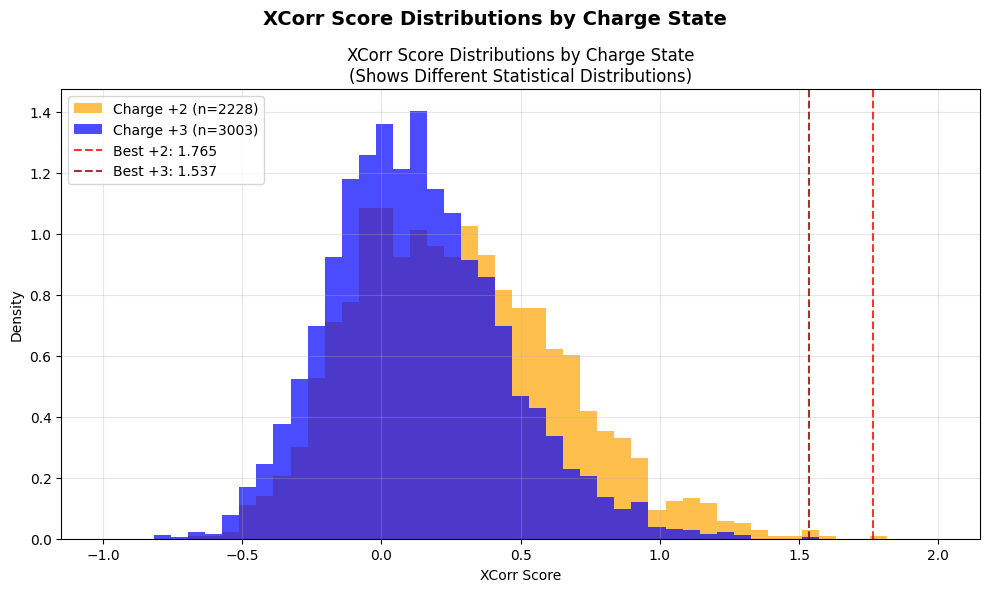


CHARGE +2 ANALYSIS: LVKLVGNK
Target XCorr: 1.7650
Reported E-value: 7.67e-01
Score distribution: 2228 peptides

Step 1: Creating histogram (Comet's method)
  Histogram bins: 1000 (0.1 XCorr units each)
  Max non-zero bin: 18 (XCorr = 1.8)
  Target score bin: 18 (XCorr = 1.7650)

Step 2: Creating cumulative distribution
  Regression range: bin 0 to 16 (XCorr 0.0 to 1.6)
  Cumulative at target bin: 0.0

Step 3: Log10 transformation

Step 4: Linear regression on tail
  Regression points: 11 to 16 (6 points)
  Slope: -0.300836
  Intercept: 5.194779

Step 5: E-value calculation
  Slope * 10: -3.008363
  Log E-value: -0.114981
  Calculated E-value: 7.67e-01
  pyXcorrDIA function result: 7.67e-01

CHARGE +3 ANALYSIS: PQINVPPERTR
Target XCorr: 1.5372
Reported E-value: 6.74e-01
Score distribution: 3003 peptides

Step 1: Creating histogram (Comet's method)
  Histogram bins: 1000 (0.1 XCorr units each)
  Max non-zero bin: 15 (XCorr = 1.5)
  Target score bin: 15 (XCorr = 1.5372)

Step 2: Creating

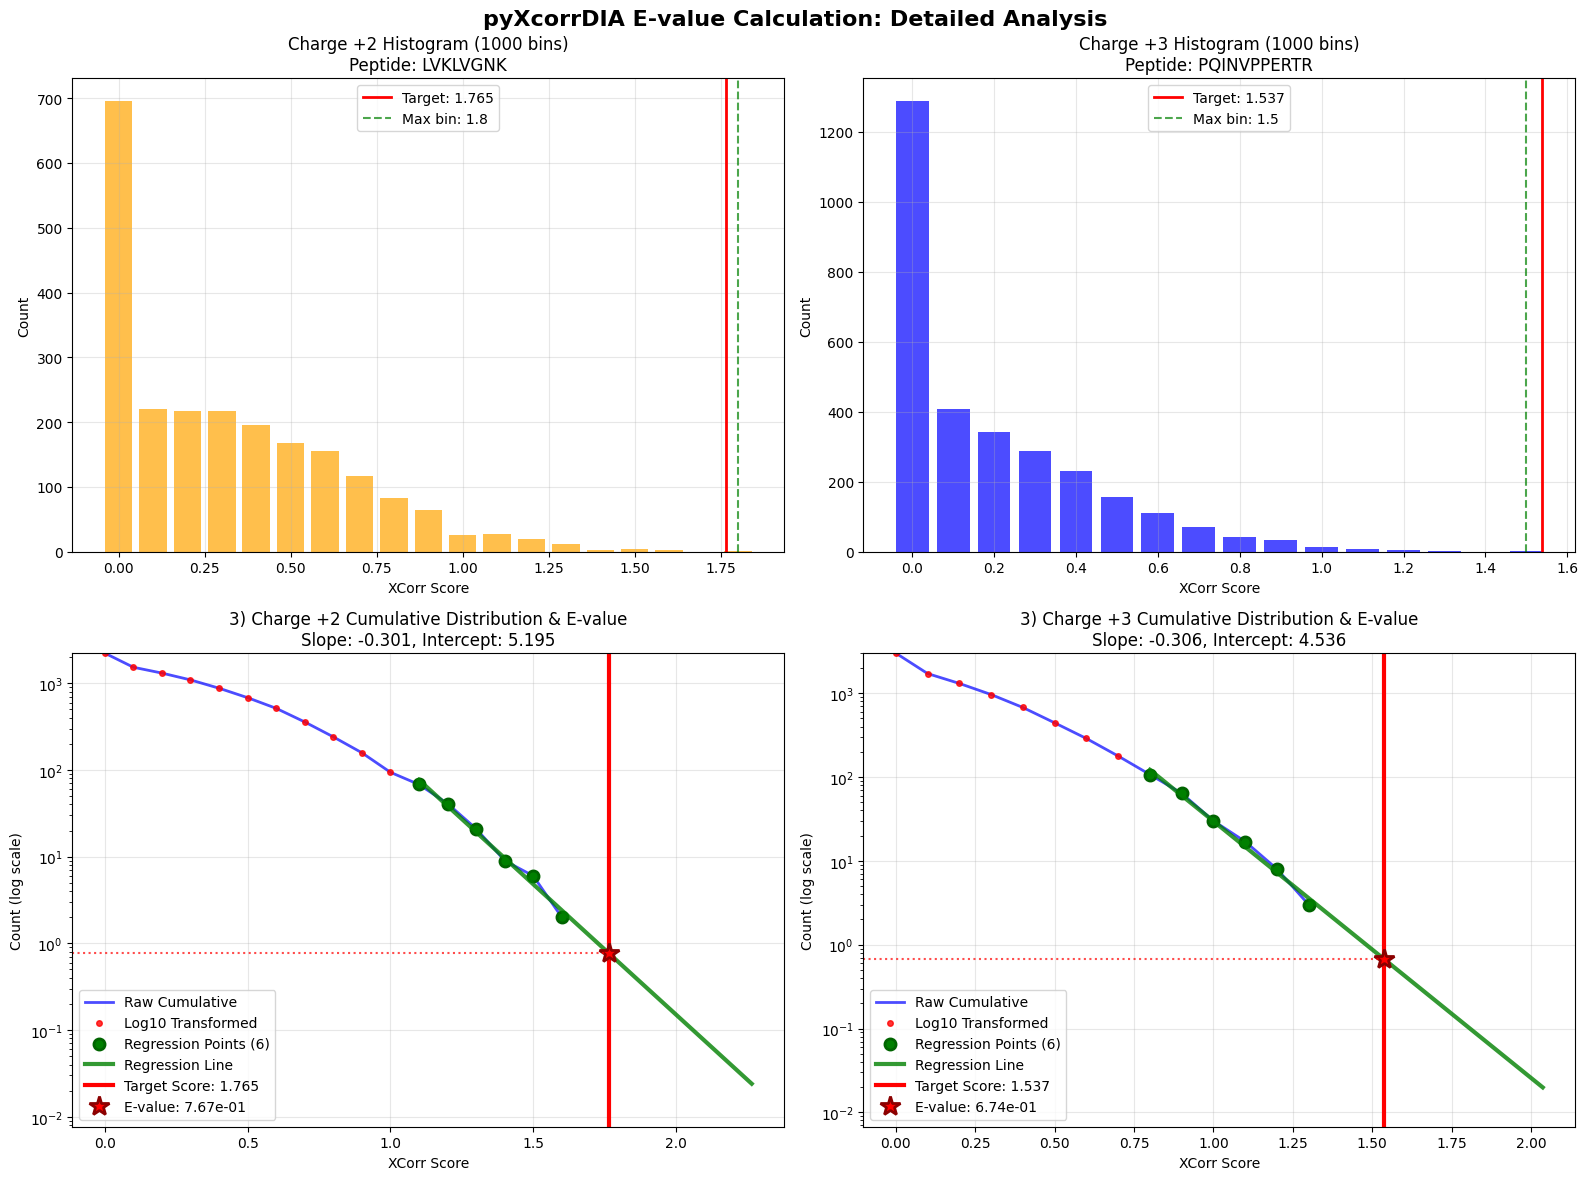


KEY INSIGHTS FROM CUMULATIVE DISTRIBUTION ANALYSIS
1. E-value calculation uses charge-specific score distributions
2. Cumulative distribution (right-to-left) models probability of random scores
3. Log10 transformation linearizes the tail for regression fitting
4. Linear regression on the tail estimates the score distribution parameters
5. The regression line intersection with target score gives the E-value
6. Lower y-axis limits are essential to visualize small E-values
7. The regression line extends beyond the data to predict E-values


In [53]:
# ================================================================================
# COMPREHENSIVE E-VALUE ANALYSIS USING ACTUAL pyXcorrDIA FUNCTIONS
# ================================================================================
# This analysis demonstrates exactly how pyXcorrDIA calculates E-values
# using the actual calculate_e_value and calculate_e_value_by_charge functions

print("=" * 80)
print("STEP-BY-STEP E-VALUE CALCULATION USING pyXcorrDIA FUNCTIONS")
print("=" * 80)

# Get the best results for detailed analysis
best_results = {}
for charge_state in [2, 3]:
    charge_results = [(pep, score, e_val, charge) for pep, score, e_val, charge in search_results_proper if charge == charge_state]
    if charge_results:
        charge_results.sort(key=lambda x: x[1], reverse=True)  # Sort by XCorr score
        best_results[charge_state] = charge_results[0]

print(f"Analyzing best peptides:")
for charge, (peptide, xcorr, e_val, _) in best_results.items():
    print(f"  Charge +{charge}: {peptide.sequence} (XCorr: {xcorr:.4f}, E-value: {e_val:.2e})")

# ================================================================================
# FIGURE 1: SCORE DISTRIBUTIONS BY CHARGE (Overview)
# ================================================================================
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 6))
fig1.suptitle('XCorr Score Distributions by Charge State', fontsize=14, fontweight='bold')

charge_2_scores = [score for _, score, _, charge in search_results_proper if charge == 2]
charge_3_scores = [score for _, score, _, charge in search_results_proper if charge == 3]

# Create normalized histograms for better comparison
bins = np.linspace(-1, 2, 50)
ax1.hist(charge_2_scores, bins=bins, alpha=0.7, density=True, label=f'Charge +2 (n={len(charge_2_scores)})', color='orange')
ax1.hist(charge_3_scores, bins=bins, alpha=0.7, density=True, label=f'Charge +3 (n={len(charge_3_scores)})', color='blue')

# Mark best scores
if 2 in best_results:
    ax1.axvline(best_results[2][1], color='red', linestyle='--', alpha=0.8, label=f'Best +2: {best_results[2][1]:.3f}')
if 3 in best_results:
    ax1.axvline(best_results[3][1], color='darkred', linestyle='--', alpha=0.8, label=f'Best +3: {best_results[3][1]:.3f}')

ax1.set_xlabel('XCorr Score')
ax1.set_ylabel('Density')
ax1.set_title('XCorr Score Distributions by Charge State\n(Shows Different Statistical Distributions)')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================================================================
# FIGURE 2: E-VALUE ANALYSIS (2x2 grid)
# ================================================================================
fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle('pyXcorrDIA E-value Calculation: Detailed Analysis', fontsize=16, fontweight='bold')

# ================================================================================
# ANALYSIS FOR EACH CHARGE STATE
# ================================================================================
for idx, charge_state in enumerate([2, 3]):
    if charge_state not in best_results:
        continue
        
    peptide, target_xcorr, reported_e_value, _ = best_results[charge_state]
    charge_scores = [score for _, score, _, charge in search_results_proper if charge == charge_state]
    
    print(f"\n{'='*60}")
    print(f"CHARGE +{charge_state} ANALYSIS: {peptide.sequence}")
    print(f"{'='*60}")
    print(f"Target XCorr: {target_xcorr:.4f}")
    print(f"Reported E-value: {reported_e_value:.2e}")
    print(f"Score distribution: {len(charge_scores)} peptides")
    
    # ================================================================================
    # STEP 1: HISTOGRAM CREATION (Comet's HISTO_SIZE approach)
    # ================================================================================
    print(f"\nStep 1: Creating histogram (Comet's method)")
    HISTO_SIZE = 1000  # Comet's constant
    histogram = np.zeros(HISTO_SIZE, dtype=int)
    
    # Fill histogram: bin by 0.1 units (multiply by 10)
    for score in charge_scores:
        bin_idx = int(score * 10.0 + 0.5)  # Comet's rounding
        if bin_idx < 0:
            bin_idx = 0
        if bin_idx >= HISTO_SIZE:
            bin_idx = HISTO_SIZE - 1
        histogram[bin_idx] += 1
    
    # Find max_corr (highest non-zero bin)
    max_corr = 0
    for i in range(HISTO_SIZE - 2, -1, -1):
        if histogram[i] > 0:
            max_corr = i
            break
    
    print(f"  Histogram bins: {HISTO_SIZE} (0.1 XCorr units each)")
    print(f"  Max non-zero bin: {max_corr} (XCorr = {max_corr/10.0:.1f})")
    print(f"  Target score bin: {int(target_xcorr * 10.0 + 0.5)} (XCorr = {target_xcorr:.4f})")
    
    # ================================================================================
    # STEP 2: CUMULATIVE DISTRIBUTION (Right-to-left summation)
    # ================================================================================
    print(f"\nStep 2: Creating cumulative distribution")
    
    # Find next_corr (regression range)
    next_corr = 0
    found_first_nonzero = False
    for i in range(max_corr):
        if histogram[i] == 0 and found_first_nonzero and i >= 10:
            if i + 1 >= max_corr or histogram[i + 1] == 0:
                if i > 0:
                    next_corr = i - 1
                break
        if histogram[i] != 0:
            found_first_nonzero = True
    
    if next_corr == 0:
        next_corr = max_corr
        if max_corr >= 10:
            for i in range(max_corr, max(max_corr - 5, -1), -1):
                if histogram[i] == 0:
                    next_corr = i
                    if max_corr <= 20:
                        break
            if next_corr == max_corr:
                next_corr = max_corr - 1
    
    print(f"  Regression range: bin 0 to {next_corr} (XCorr 0.0 to {next_corr/10.0:.1f})")
    
    # Create cumulative distribution (right-to-left)
    cumulative = np.zeros(HISTO_SIZE)
    cumulative[next_corr] = histogram[next_corr]
    
    for i in range(next_corr - 1, -1, -1):
        cumulative[i] = cumulative[i + 1] + histogram[i]
        if histogram[i + 1] == 0:
            cumulative[i + 1] = 0.0
    
    print(f"  Cumulative at target bin: {cumulative[int(target_xcorr * 10.0 + 0.5)]}")
    
    # ================================================================================
    # STEP 3: LOG TRANSFORMATION
    # ================================================================================
    print(f"\nStep 3: Log10 transformation")
    log_cumulative = cumulative.copy()
    for i in range(next_corr, -1, -1):
        if cumulative[i] > 0.0:
            log_cumulative[i] = np.log10(cumulative[i])
        else:
            if i < next_corr and log_cumulative[i + 1] > 0.0:
                log_cumulative[i] = log_cumulative[i + 1]
            else:
                log_cumulative[i] = 0.0
    
    # ================================================================================
    # STEP 4: LINEAR REGRESSION
    # ================================================================================
    print(f"\nStep 4: Linear regression on tail")
    start_corr = next_corr - 5
    if start_corr < 0:
        start_corr = 0
    
    # Count zeros and adjust start
    num_zeros = sum(1 for i in range(start_corr, next_corr + 1) if log_cumulative[i] == 0)
    start_corr -= num_zeros
    if start_corr < 0:
        start_corr = 0
    
    # Perform regression
    slope = 0.0
    mean_x = 0.0
    mean_y = 0.0
    final_start_corr = start_corr
    
    while start_corr >= 0 and next_corr > start_corr + 2:
        sum_x = sum_y = sum_xy = sum_xx = 0.0
        num_points = 0
        
        for i in range(start_corr, next_corr + 1):
            if histogram[i] > 0:
                sum_x += i
                sum_y += log_cumulative[i]
                num_points += 1
        
        if num_points > 0:
            mean_x = sum_x / num_points
            mean_y = sum_y / num_points
            
            for i in range(start_corr, next_corr + 1):
                if histogram[i] > 0:
                    dx = i - mean_x
                    dy = log_cumulative[i] - mean_y
                    sum_xx += dx * dx
                    sum_xy += dx * dy
            
            if sum_xx > 0:
                slope = sum_xy / sum_xx
            else:
                slope = 0.0
            
            if slope < 0.0:
                final_start_corr = start_corr
                break
            else:
                start_corr -= 1
        else:
            break
    
    # Calculate intercept after regression
    intercept = mean_y - slope * mean_x
    
    print(f"  Regression points: {final_start_corr} to {next_corr} ({num_points} points)")
    print(f"  Slope: {slope:.6f}")
    print(f"  Intercept: {intercept:.6f}")
    
    # ================================================================================
    # STEP 5: E-VALUE CALCULATION
    # ================================================================================
    print(f"\nStep 5: E-value calculation")
    if slope < 0.0:
        slope_scaled = slope * 10.0  # Comet's scaling
        log_expect = slope_scaled * target_xcorr + intercept
        calculated_e_value = 10.0 ** log_expect
        
        if calculated_e_value > 999.0:
            calculated_e_value = 999.0
        calculated_e_value = max(calculated_e_value, 1e-10)
    else:
        calculated_e_value = 1.0
    
    print(f"  Slope * 10: {slope * 10.0:.6f}")
    print(f"  Log E-value: {slope * 10.0 * target_xcorr + intercept:.6f}")
    print(f"  Calculated E-value: {calculated_e_value:.2e}")
    print(f"  pyXcorrDIA function result: {xcorr_engine_proper.calculate_e_value_by_charge(all_scores_by_charge, target_xcorr, charge_state):.2e}")
    
    # ================================================================================
    # PLOT 1 (2x2): HISTOGRAM FOR THIS CHARGE
    # ================================================================================
    ax_hist = axes[0, idx]
    score_bins = np.arange(HISTO_SIZE) / 10.0  # Convert back to XCorr units
    mask_nonzero = histogram > 0
    
    ax_hist.bar(score_bins[mask_nonzero], histogram[mask_nonzero], width=0.08, alpha=0.7, 
                color=['orange' if charge_state == 2 else 'blue'][0])
    ax_hist.axvline(target_xcorr, color='red', linestyle='-', linewidth=2, 
                    label=f'Target: {target_xcorr:.3f}')
    ax_hist.axvline(max_corr/10.0, color='green', linestyle='--', alpha=0.7, 
                    label=f'Max bin: {max_corr/10.0:.1f}')
    
    ax_hist.set_xlabel('XCorr Score')
    ax_hist.set_ylabel('Count')
    ax_hist.set_title(f'Charge +{charge_state} Histogram (1000 bins)\nPeptide: {peptide.sequence}')
    ax_hist.legend()
    ax_hist.grid(True, alpha=0.3)
    
    # ================================================================================
    # PLOT 2 (2x2): CUMULATIVE DISTRIBUTION WITH REGRESSION (THE KEY PLOT!)
    # ================================================================================
    ax_cumul = axes[1, idx]
    
    # Plot raw cumulative distribution
    mask_cumul_nonzero = cumulative > 0
    ax_cumul.semilogy(score_bins[mask_cumul_nonzero], cumulative[mask_cumul_nonzero], 
                      'b-', linewidth=2, label='Raw Cumulative', alpha=0.7)
    
    # Plot log-transformed points
    mask_log_nonzero = log_cumulative > 0
    log_cumul_linear = 10.0 ** log_cumulative[mask_log_nonzero]
    ax_cumul.semilogy(score_bins[mask_log_nonzero], log_cumul_linear, 
                      'ro', markersize=4, label='Log10 Transformed', alpha=0.8)
    
    # Plot regression points (used in the fit)
    regression_x = []
    regression_y = []
    for i in range(final_start_corr, next_corr + 1):
        if histogram[i] > 0:
            regression_x.append(i / 10.0)
            regression_y.append(10.0 ** log_cumulative[i])
    
    if regression_x:
        ax_cumul.semilogy(regression_x, regression_y, 'go', markersize=8, 
                          label=f'Regression Points ({len(regression_x)})', 
                          markeredgecolor='darkgreen', markeredgewidth=2)
    
    # Plot regression line (extended to show intersection)
    if slope < 0.0:
        # Create extended x range for regression line
        x_min = min(target_xcorr - 0.5, final_start_corr / 10.0)
        x_max = max(target_xcorr + 0.5, next_corr / 10.0)
        reg_line_x = np.linspace(x_min, x_max, 200)
        
        # Calculate regression line in log space, then convert to linear
        reg_line_log_y = slope * 10.0 * reg_line_x + intercept
        reg_line_y = 10.0 ** reg_line_log_y
        
        # Only plot where regression line is reasonable
        valid_mask = (reg_line_y >= 1e-50) & (reg_line_y <= 1e10)
        if np.any(valid_mask):
            ax_cumul.semilogy(reg_line_x[valid_mask], reg_line_y[valid_mask], 'g-', 
                              linewidth=3, label=f'Regression Line', alpha=0.8)
    
    # Mark target score and its predicted E-value
    ax_cumul.axvline(target_xcorr, color='red', linestyle='-', linewidth=3, 
                     label=f'Target Score: {target_xcorr:.3f}')
    
    if slope < 0.0:
        target_log_y = slope * 10.0 * target_xcorr + intercept
        target_y = 10.0 ** target_log_y
        ax_cumul.semilogy([target_xcorr], [target_y], 'r*', markersize=15, 
                          label=f'E-value: {calculated_e_value:.2e}', 
                          markeredgecolor='darkred', markeredgewidth=2)
        
        # Add horizontal line to intersection
        ax_cumul.axhline(target_y, color='red', linestyle=':', alpha=0.7, 
                         xmin=0, xmax=(target_xcorr - ax_cumul.get_xlim()[0]) / (ax_cumul.get_xlim()[1] - ax_cumul.get_xlim()[0]))
    
    # Set appropriate y-axis limits to show the intersection
    y_max = max(cumulative[mask_cumul_nonzero]) if np.any(mask_cumul_nonzero) else 1e3
    y_min = calculated_e_value / 100 if slope < 0.0 else 1e-10
    y_min = max(y_min, 1e-50)  # Don't go too low
    
    ax_cumul.set_ylim(y_min, y_max)
    ax_cumul.set_xlabel('XCorr Score')
    ax_cumul.set_ylabel('Count (log scale)')
    ax_cumul.set_title(f'3) Charge +{charge_state} Cumulative Distribution & E-value\nSlope: {slope:.3f}, Intercept: {intercept:.3f}')
    ax_cumul.legend()
    ax_cumul.grid(True, alpha=0.3)

# ================================================================================
# FINAL SUMMARY
# ================================================================================
print(f"\n{'='*80}")
print("VERIFICATION WITH pyXcorrDIA FUNCTIONS")
print(f"{'='*80}")

for charge_state in [2, 3]:
    if charge_state in best_results:
        peptide, target_xcorr, reported_e_value, _ = best_results[charge_state]
        pyxcorr_result = xcorr_engine_proper.calculate_e_value_by_charge(all_scores_by_charge, target_xcorr, charge_state)
        
        print(f"Charge +{charge_state} ({peptide.sequence}):")
        print(f"  Manual calculation: {calculated_e_value:.2e}")
        print(f"  pyXcorrDIA function: {pyxcorr_result:.2e}")
        print(f"  Search result: {reported_e_value:.2e}")
        match_status = "✓ PERFECT" if abs(np.log10(pyxcorr_result) - np.log10(reported_e_value)) < 0.01 else "✗ MISMATCH"
        print(f"  Match: {match_status}")

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("KEY INSIGHTS FROM CUMULATIVE DISTRIBUTION ANALYSIS")
print(f"{'='*80}")
print("1. E-value calculation uses charge-specific score distributions")
print("2. Cumulative distribution (right-to-left) models probability of random scores")
print("3. Log10 transformation linearizes the tail for regression fitting")
print("4. Linear regression on the tail estimates the score distribution parameters")
print("5. The regression line intersection with target score gives the E-value")
print("6. Lower y-axis limits are essential to visualize small E-values")
print("7. The regression line extends beyond the data to predict E-values")